# Przewidywanie zagrożenia uderzenia asteroidy w Ziemię na podstawie parametrów asteroidy

Celem niniejszej analizy jest zbudowanie i porównanie kilku modeli uczenia maszynowego, których zadaniem jest klasyfikacja binarna asteroid na podstawie dostarczonych danych jako obiektów, które zagrażają lub nie zagrażają zderzeniem z Ziemią.

## 1. Zbieranie danych

Analiza będzie oparta na zbiorze danych 'NASA: Asteroids Classification' dostępnym na kaggle.com. Dane objęte są licencją CC0: Public Domain. Dane pochodzą z CNEOS (Center for Near Earth Object Studies, http://neo.jpl.nasa.gov/), który jest ośrodkiem NASA zajmującym się obliczaniem orbit asteroid i komet oraz prawdopodobieństwa zderzenia tych obiektów z Ziemią. API utrzymywane jest przez zespół SpaceRocks w składzie: David Greenfield, Arezu Sarvestani, Jason English i Peter Baunach.

Zbiór zawiera szczegółowe dane 4687 asteroid, takie jak rozmiary, data zbliżenia do Ziemi, odległość od Ziemi w momencie zbliżenia, prędkość obiektu i wiele innych parametrów opisanych poniżej, które mogą mieć wpływ na to, czy w przypadku danego obiektu istnieje zagrożenie uderzenia w Ziemię. W oparciu o te cechy utworzone zostanie kilka modeli uczenia maszynowego, a następnie porównana zostanie dokładność i zdolność przewidywania tych modeli. 

Na początek zainstalujmy podstawowe biblioteki, które będą nam potrzebne:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

Pobierzmy dane, zapiszmy je w zmiennej typu DataFrame df i przyjrzyjmy się ich początkowym rekordom:

In [2]:
path = r'D:\Coder\Datasets\nasa.csv'
df = pd.read_csv(path)
df.head()

,Neo Reference ID,Name,Absolute Magnitude,Est Dia in KM(min),Est Dia in KM(max),Est Dia in M(min),Est Dia in M(max),Est Dia in Miles(min),Est Dia in Miles(max),Est Dia in Feet(min),...,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion,Equinox,Hazardous
0,3703080,3703080,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,...,314.373913,609.599786,0.808259,57.257470,2.005764,2.458162e+06,264.837533,0.590551,J2000,True
1,3723955,3723955,21.3,0.146068,0.326618,146.067964,326.617897,0.090762,0.202951,479.225620,...,136.717242,425.869294,0.718200,313.091975,1.497352,2.457795e+06,173.741112,0.845330,J2000,False
2,2446862,2446862,20.3,0.231502,0.517654,231.502122,517.654482,0.143849,0.321655,759.521423,...,259.475979,643.580228,0.950791,248.415038,1.966857,2.458120e+06,292.893654,0.559371,J2000,True
3,3092506,3092506,27.4,0.008801,0.019681,8.801465,19.680675,0.005469,0.012229,28.876199,...,57.173266,514.082140,0.983902,18.707701,1.527904,2.457902e+06,68.741007,0.700277,J2000,False
4,3514799,3514799,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,...,84.629307,495.597821,0.967687,158.263596,1.483543,2.457814e+06,135.142133,0.726395,J2000,True


### Opis danych

Widzimy tu tylko część kolumn. Większość danych jest typu numerycznego, ale są także dane innych typów. Sprawdźmy podstawowe informacje o zbiorze: 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4687 entries, 0 to 4686
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Neo Reference ID              4687 non-null   int64  
 1   Name                          4687 non-null   int64  
 2   Absolute Magnitude            4687 non-null   float64
 3   Est Dia in KM(min)            4687 non-null   float64
 4   Est Dia in KM(max)            4687 non-null   float64
 5   Est Dia in M(min)             4687 non-null   float64
 6   Est Dia in M(max)             4687 non-null   float64
 7   Est Dia in Miles(min)         4687 non-null   float64
 8   Est Dia in Miles(max)         4687 non-null   float64
 9   Est Dia in Feet(min)          4687 non-null   float64
 10  Est Dia in Feet(max)          4687 non-null   float64
 11  Close Approach Date           4687 non-null   object 
 12  Epoch Date Close Approach     4687 non-null   int64  
 13  Rel

Jak widać, df składa się z 4687 wierszy, z czego każdy wiersz reprezentuje jedną asteroidę i 40 kolumn, z czego każda kolumna reprezentuje jedną cechę. 

W zbiorze nie ma brakujących danych w żadnej kolumnie. Większość kolumn jest typu zmiennoprzecinkowego (float), 5 kolumn jest typu całkowitego (int), 4 kolumny są typu object (stringi i daty) oraz jedna kolumna jest typu bool (kolumna Hazardous, w której znajduje się nasza wartość docelowa).  

Przyjrzyjmy się teraz poszczególnym kolumnom:

- Neo Reference ID - unikalny identyfikator obiektu
- Name - nazwa obiektu
- Absolute Magnitude - absolutna wielkość gwiazdowa, czyli jasność obiektu widziana z ustalonej odległości bez wpływu atmosfery i innych czynników, podawana jako wartość bezwymiarowa - wartości mniejsze odpowiadają wyższym jasnościom
- Est Dia in KM(min) - minimalna szacowana średnica asteroidy w kilometrach
- Est Dia in KM(max) - maksymalna szacowana średnica asteroidy w kilometrach
- Est Dia in M(min) - minimalna szacowana średnica asteroidy w metrach
- Est Dia in M(max) - maksymalna szacowana średnica asteroidy w metrach
- Est Dia in Miles(min) - minimalna szacowana średnica asteroidy w milach
- Est Dia in Miles(max) - maksymalna szacowana średnica asteroidy w milach
- Est Dia in Feet(min) - minimalna szacowana średnica asteroidy w stopach
- Est Dia in Feet(max) - maksymalna szacowana średnica asteroidy w stopach
- Close Approach Date - data maksymalnego zbliżenia do Ziemi
- Epoch Date Close Approach - data maksymalnego zbliżenia do Ziemi liczona od początku epoki
- Relative Velocity km per sec - prędkość asteroidy względem Ziemi w km/s
- Relative Velocity km per hr - prędkość asteroidy względem Ziemi w km/h
- Miles per hour - prędkość asteroidy w milach/h
- Miss Dist.(Astronomical) - minimalna odległość asteroidy od Ziemi wyrażona w jednostkach astronomicznych (AU)
- Miss Dist.(lunar) - minimalna odległość asteroidy od Ziemi wyrażona jako wielokrotność średniej odległości Ziemia-Księżyc
- Miss Dist.(kilometers) - minimalna odległość asteroidy od Ziemi w km
- Miss Dist.(miles) - minimalna odległość asteroidy od Ziemi w milach
- Orbiting Body - ciało niebieskie, wokół którego porusza się asteroida
- Orbit ID - identyfikator orbity asteroidy
- Orbit Determination Date - data ostatniej aktualizacji parametrów orbity
- Orbit Uncertainty - stopień niepewności obliczeń orbity
- Minimum Orbit Intersection - minimalna odległość między orbitami Ziemi i asteroidy
- Jupiter Tisserand Invariant - niezmiennik Tisseranda względem Jowisza, czyli wskaźnik określający charakter orbity asteroidy względem Jowisza
- Epoch Osculation - oskulacja epokowa
- Eccentricity - ekscentryczność, czyli miara wydłużenia orbity asteroidy
- Semi Major Axis - półoś wielka (połowa maksymalnej średnicy orbity w jednostkach astronomicznych)
- Inclination - inklinacja, czyli kąt nachylenia orbity asteroidy w stopniach
- Asc Node Longitude - długość węzła wstępującego
- Orbital Period - okres orbitalny, czyli czas jednego pełnego obiegu orbitalnego
- Perihelion Distance - odległość peryhelium, czyli najmniejsza odległość asteroidy od Słońca
- Perihelion Arg - argument peryhelium określający pozycję peryhelium w płaszczyźnie orbity
- Aphelion Dist - odległość aphelium, czyli największa odległość asteroidy od Słońca
- Perihelion Time - czas peryhelium, czyli moment kiedy asteroida znajduje sie w peryhelium
- Mean Anomaly - anomalia średnia, czyli parametr kątowy wiążący położenie ciała z czasem
- Mean Motion - średnia prędkość kątowa asteroidy na orbicie
- Equinox - używana epoka, czyli punkt odniesienia dla obliczeń orbitalnych
- Hazardous - niebezpieczna, czyli czy asteroida stanowi potencjalne zagrożenie dla Ziemi

Ostatnia kolumna zawiera etykietę (wartość docelową), którą nasze modele będą przewidywać na danych testowych. Może ona przyjmować 2 wartości: True (niebezpieczna) i False (bezpieczna).

## 2. Eksploracyjna analiza danych (Exploratory Data Analysis, EDA) i inżynieria cech (Feature Engineering)

### Wstępne przetwarzanie i czyszczenie danych

Przed przystąpieniem do analizy danych, dane należy w miarę potrzeby wyczyścić i wstępnie przetworzyć. Proces ten obejmuje następujące czynności:

- usunięcie zbędnych wierszy i kolumn
- obsługa brakujących danych
- usunięcie duplikatów
- transformacje danych

Na tym etapie dokonamy jedynie wstępnej analizy danych. W dalszej kolejności przyjrzymy się danym dokładniej i dokonamy ich wizualizacji. Wtedy, o ile będzie to wskazane, ponownie przeprowadzimy niektóre z powyższych czynności, takie jak usunięcie zbędnych wierszy i kolumn czy transformacje danych.

#### Usunięcie zbędnych wierszy i kolumn

Nasze DataFrame zawiera bardzo dużo kolumn, więc na początek spróbujmy ustalić, czy niektóre z tych kolumn można usunąć. Na pewno nie potrzebujemy kolumn w sposób unikatowy opisujących dane, gdyż nie nadają się one do przewidywania wartości w zbiorze testowym. Należą tu kolumny Neo Reference ID oraz Name. Nie potrzebujemy też kolumn zawierających datę maksymalnego zbliżenia, gdyż model ma przewidywać zagrożenie występujące w przyszłości, dlatego możemy usunąć kolumny Close Approach Date i Epoch Date Close Approach, a także czasu peryhelium, czyli kolumny Perihelion Time.

Nie będziemy także potrzebować danych identyfikujących i opisujących orbitę, a więc zawartych w kolumnach Orbit ID i Orbit Determination Date. 

Poza tym możemy usunąć kolumny, które we wszystkich wierszach zawierają tą samą wartość. Sprawdźmy, ile unikatowych wartości zawierają poszczególne kolumny:

In [4]:
df.nunique()

Neo Reference ID                3692
Name                            3692
Absolute Magnitude               269
Est Dia in KM(min)               269
Est Dia in KM(max)               269
Est Dia in M(min)                269
Est Dia in M(max)                269
Est Dia in Miles(min)            269
Est Dia in Miles(max)            269
Est Dia in Feet(min)             269
Est Dia in Feet(max)             269
Close Approach Date              777
Epoch Date Close Approach        777
Relative Velocity km per sec    4687
Relative Velocity km per hr     4687
Miles per hour                  4687
Miss Dist.(Astronomical)        4673
Miss Dist.(lunar)               4660
Miss Dist.(kilometers)          4661
Miss Dist.(miles)               4660
Orbiting Body                      1
Orbit ID                         188
Orbit Determination Date        2680
Orbit Uncertainity                10
Minimum Orbit Intersection      3678
Jupiter Tisserand Invariant     2495
Epoch Osculation                 429
E

Jak widać, kolumny Orbiting Body i Equinox zawierają taką samą wartość w każdym wierszu, więc nie wnoszą nic do analizy. 

Poza tym, nasze DataFrame zawiera liczne kolumny, w których zawarta jest ta sama informacja, ale z użyciem innych jednostek. Można tu wyróżnić następujące grupy kolumn:

1) minimalna szacowana średnica asteroidy:
   - Est Dia in KM(min) 
   - Est Dia in M(min)
   - Est Dia in Miles(min)
   - Est Dia in Feet(min)
2) maksymalna szacowana średnica asteroidy:
   - Est Dia in KM(max)
   - Est Dia in M(max)
   - Est Dia in Miles(max)
   - Est Dia in Feet(max)
3) prędkość asteroidy względem Ziemi:
   - Relative Velocity km per sec
   - Relative Velocity km per hr
   - Miles per hour
4) minimalna odległość asteroidy od Ziemi:
   - Miss Dist.(Astronomical)
   - Miss Dist.(lunar)
   - Miss Dist.(kilometers)
   - Miss Dist.(miles)
  
W każdej z powyższej grup zostawimy tylko jedną kolumnę. W szczególności pozostawimy następujące kolumny:
- Est Dia in KM(min)
- Est Dia in KM(max)
- Relative Velocity km per hr
- Miss Dist.(kilometers)

Pozostałe kolumny usuniemy. 

Lista kolumn do usunięcia przedstawia się następująco:

In [5]:
kolumny_do_usuniecia = [
    'Neo Reference ID',
    'Name',
    'Est Dia in M(min)',
    'Est Dia in M(max)',
    'Est Dia in Miles(min)',
    'Est Dia in Miles(max)',
    'Est Dia in Feet(min)',
    'Est Dia in Feet(max)',    
    'Close Approach Date',
    'Epoch Date Close Approach',
    'Relative Velocity km per sec',
    'Miles per hour',
    'Miss Dist.(Astronomical)',
    'Miss Dist.(lunar)',
    'Miss Dist.(miles)',
    'Orbiting Body',    
    'Orbit ID',
    'Orbit Determination Date',    
    'Perihelion Time',
    'Equinox'  
]

Usuńmy niepotrzebne kolumny:

In [6]:
df = df.drop(kolumny_do_usuniecia, axis=1)
df.head()

,Absolute Magnitude,Est Dia in KM(min),Est Dia in KM(max),Relative Velocity km per hr,Miss Dist.(kilometers),Orbit Uncertainity,Minimum Orbit Intersection,Jupiter Tisserand Invariant,Epoch Osculation,Eccentricity,Semi Major Axis,Inclination,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Mean Anomaly,Mean Motion,Hazardous
0,21.6,0.127220,0.284472,22017.003799,62753692.0,5,0.025282,4.634,2458000.5,0.425549,1.407011,6.025981,314.373913,609.599786,0.808259,57.257470,2.005764,264.837533,0.590551,True
1,21.3,0.146068,0.326618,65210.346095,57298148.0,3,0.186935,5.457,2458000.5,0.351674,1.107776,28.412996,136.717242,425.869294,0.718200,313.091975,1.497352,173.741112,0.845330,False
2,20.3,0.231502,0.517654,27326.560182,7622911.5,0,0.043058,4.557,2458000.5,0.348248,1.458824,4.237961,259.475979,643.580228,0.950791,248.415038,1.966857,292.893654,0.559371,True
3,27.4,0.008801,0.019681,40225.948191,42683616.0,6,0.005512,5.093,2458000.5,0.216578,1.255903,7.905894,57.173266,514.082140,0.983902,18.707701,1.527904,68.741007,0.700277,False
4,21.6,0.127220,0.284472,35426.991794,61010824.0,1,0.034798,5.154,2458000.5,0.210448,1.225615,16.793382,84.629307,495.597821,0.967687,158.263596,1.483543,135.142133,0.726395,True


#### Brakujące dane

Jak wykazaliśmy wcześniej, nasz zbiór danych nie zawiera brakujących danych, więc nie mamy w tym zakresie nic do zrobienia. W razie występowania brakujących danych moglibyśmy rozważyć wypełnienie ich wartościami średnimi, równymi medianie, interpolowanymi, albo wyliczonymi w jakiś inny sposób, a także całkowite usunięcie wierszy lub kolumn, w których dane takie by występowały. 

#### Duplikaty

Kolejna czynność to usunięcie duplikatów. Duplikaty to powtarzające się wiersze. Sprawdźmy, czy w naszym zbiorze duplikaty w ogóle występują:

In [7]:
df.duplicated().any()

False

Jak widać, w naszym DataFrame nie ma duplikatów.

#### Transformacje danych

Zanim zajmiemy się ewentualnymi transformacjami danych, zmieńmy nagłówki kolumn na polskojęzyczne i zmieńmy ich pisownię na zaczynającą się od małej litery (aktualnie nagłówki zaczynają się od dużej litery):

In [8]:
kolumny_pl = [
    'absolutna wielkość gwiazdowa', 
    'średnica min km', 
    'średnica max km', 
    'prędkość kmh', 
    'min odległość od Ziemi km', 
    'niepewność orbity', 
    'min odległość orbit', 
    'niezmiennik Tisseranda względem Jowisza', 
    'oskulacja epokowa', 
    'ekscentryczność', 
    'półoś wielka', 
    'inklinacja',
    'długość węzła wstępującego',
    'okres orbitalny',
    'odległość peryhelium',
    'argument peryhelium',
    'odległość aphelium',
    'anomalia średnia',
    'średnia prędkość kątowa',
    'zagrożenie'
]
df.columns = kolumny_pl
df.head()

,absolutna wielkość gwiazdowa,średnica min km,średnica max km,prędkość kmh,min odległość od Ziemi km,niepewność orbity,min odległość orbit,niezmiennik Tisseranda względem Jowisza,oskulacja epokowa,ekscentryczność,półoś wielka,inklinacja,długość węzła wstępującego,okres orbitalny,odległość peryhelium,argument peryhelium,odległość aphelium,anomalia średnia,średnia prędkość kątowa,zagrożenie
0,21.6,0.127220,0.284472,22017.003799,62753692.0,5,0.025282,4.634,2458000.5,0.425549,1.407011,6.025981,314.373913,609.599786,0.808259,57.257470,2.005764,264.837533,0.590551,True
1,21.3,0.146068,0.326618,65210.346095,57298148.0,3,0.186935,5.457,2458000.5,0.351674,1.107776,28.412996,136.717242,425.869294,0.718200,313.091975,1.497352,173.741112,0.845330,False
2,20.3,0.231502,0.517654,27326.560182,7622911.5,0,0.043058,4.557,2458000.5,0.348248,1.458824,4.237961,259.475979,643.580228,0.950791,248.415038,1.966857,292.893654,0.559371,True
3,27.4,0.008801,0.019681,40225.948191,42683616.0,6,0.005512,5.093,2458000.5,0.216578,1.255903,7.905894,57.173266,514.082140,0.983902,18.707701,1.527904,68.741007,0.700277,False
4,21.6,0.127220,0.284472,35426.991794,61010824.0,1,0.034798,5.154,2458000.5,0.210448,1.225615,16.793382,84.629307,495.597821,0.967687,158.263596,1.483543,135.142133,0.726395,True


Odrzuciliśmy wiele kolumn. Sprawdźmy jakiego typu dane zawierają kolumny, które pozostawiliśmy:

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4687 entries, 0 to 4686
Data columns (total 20 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   absolutna wielkość gwiazdowa             4687 non-null   float64
 1   średnica min km                          4687 non-null   float64
 2   średnica max km                          4687 non-null   float64
 3   prędkość kmh                             4687 non-null   float64
 4   min odległość od Ziemi km                4687 non-null   float64
 5   niepewność orbity                        4687 non-null   int64  
 6   min odległość orbit                      4687 non-null   float64
 7   niezmiennik Tisseranda względem Jowisza  4687 non-null   float64
 8   oskulacja epokowa                        4687 non-null   float64
 9   ekscentryczność                          4687 non-null   float64
 10  półoś wielka                             4687 no

Pozostało 20 kolumn. Nie ma już kolumn typu object. Wszystkie kolumny z wyjątkiem ostatniej są typu numerycznego (float i w jednej kolumnie int). Zamieńmy ostatnią kolumnę na typ numeryczny, gdzie wartościom True przypiszemy 1, a wartościom False przypiszemy 0:

In [10]:
df['zagrożenie'] = df['zagrożenie'].map({True: 1, False: 0})
df.head()

,absolutna wielkość gwiazdowa,średnica min km,średnica max km,prędkość kmh,min odległość od Ziemi km,niepewność orbity,min odległość orbit,niezmiennik Tisseranda względem Jowisza,oskulacja epokowa,ekscentryczność,półoś wielka,inklinacja,długość węzła wstępującego,okres orbitalny,odległość peryhelium,argument peryhelium,odległość aphelium,anomalia średnia,średnia prędkość kątowa,zagrożenie
0,21.6,0.127220,0.284472,22017.003799,62753692.0,5,0.025282,4.634,2458000.5,0.425549,1.407011,6.025981,314.373913,609.599786,0.808259,57.257470,2.005764,264.837533,0.590551,1
1,21.3,0.146068,0.326618,65210.346095,57298148.0,3,0.186935,5.457,2458000.5,0.351674,1.107776,28.412996,136.717242,425.869294,0.718200,313.091975,1.497352,173.741112,0.845330,0
2,20.3,0.231502,0.517654,27326.560182,7622911.5,0,0.043058,4.557,2458000.5,0.348248,1.458824,4.237961,259.475979,643.580228,0.950791,248.415038,1.966857,292.893654,0.559371,1
3,27.4,0.008801,0.019681,40225.948191,42683616.0,6,0.005512,5.093,2458000.5,0.216578,1.255903,7.905894,57.173266,514.082140,0.983902,18.707701,1.527904,68.741007,0.700277,0
4,21.6,0.127220,0.284472,35426.991794,61010824.0,1,0.034798,5.154,2458000.5,0.210448,1.225615,16.793382,84.629307,495.597821,0.967687,158.263596,1.483543,135.142133,0.726395,1


In [11]:
df['zagrożenie'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 4687 entries, 0 to 4686
Series name: zagrożenie
Non-Null Count  Dtype
--------------  -----
4687 non-null   int64
dtypes: int64(1)
memory usage: 36.7 KB


Teraz wszystkie kolumny są typu numerycznego. Wszystkie kolumny numeryczne zostaną w dalszej analizie przeskalowane do rozkładu normalnego (średnia wartość równa 0, odchylenie standardowe równe 1). Jednak na tym etapie nie jest to wskazane, gdyż dane takie byłyby mało intuicyjne podczas wizualizacji. W związku z tym na razie poprzestaniemy na transformacji kolumny docelowej, której właśnie dokonaliśmy.

### Wizualizacja danych

Wizualizacji danych dokonuje się w celu graficznego przedstawienia różnych zależności pomiędzy poszczególnymi cechami, a także w celu przedstawienia cech ilościowych danej cechy. Dzięki temu o wiele szybciej jesteśmy w stanie zrozumieć nasze dane.

Szczególnie interesują nas zależności pomiędzy cechą docelową, czyli tą, która będzie przewidywana przez modele, a pozostałymi cechami. Cechą docelową jest zagrożenie.

Nasza wizualizacja danych będzie obejmować następujące czynności:

- sumaryczne zestawienie danych statystycznych dla cech numerycznych dla całego zbioru
- obsługa wartości odstających (outliers), tzn. ich pozostawienie, zastąpienie innymi wartościami lub usunięcie
- sprawdzenie korelacji pomiędzy kolumnami i ewentualne odrzucenie kolumn bardzo słabo skorelowanych z cechą zagrożenie

#### Sumaryczne zestawienie statystyczne dla cech numerycznych

Zacznijmy od sumarycznego zestawienia danych statystycznych dla cech numerycznych:

In [12]:
df.describe()

,absolutna wielkość gwiazdowa,średnica min km,średnica max km,prędkość kmh,min odległość od Ziemi km,niepewność orbity,min odległość orbit,niezmiennik Tisseranda względem Jowisza,oskulacja epokowa,ekscentryczność,półoś wielka,inklinacja,długość węzła wstępującego,okres orbitalny,odległość peryhelium,argument peryhelium,odległość aphelium,anomalia średnia,średnia prędkość kątowa,zagrożenie
count,4687.000000,4687.000000,4687.000000,4687.000000,4.687000e+03,4687.000000,4687.000000,4687.000000,4.687000e+03,4687.000000,4687.000000,4687.000000,4687.000000,4687.000000,4687.000000,4687.000000,4687.000000,4687.000000,4687.000000,4687.000000
mean,22.267865,0.204604,0.457509,50294.919829,3.841347e+07,3.516962,0.082320,5.056111,2.457724e+06,0.382569,1.400264,13.373844,172.157275,635.582076,0.813383,183.932151,1.987144,181.167927,0.738242,0.161084
std,2.890972,0.369573,0.826391,26255.601377,2.181110e+07,3.078307,0.090300,1.237818,9.202975e+02,0.180444,0.524154,10.936227,103.276777,370.954727,0.242059,103.513035,0.951519,107.501623,0.342627,0.367647
min,11.160000,0.001011,0.002260,1207.814804,2.660989e+04,0.000000,0.000002,2.196000,2.450164e+06,0.007522,0.615920,0.014513,0.001941,176.557161,0.080744,0.006918,0.803765,0.003191,0.086285,0.000000
25%,20.100000,0.033462,0.074824,30358.313370,1.995928e+07,0.000000,0.014585,4.049500,2.458000e+06,0.240858,1.000635,4.962341,83.081208,365.605031,0.630834,95.625916,1.266059,87.006918,0.453289,0.000000
50%,21.900000,0.110804,0.247765,46504.401181,3.964771e+07,3.000000,0.047365,5.071000,2.458000e+06,0.372450,1.240981,10.311836,172.625393,504.947292,0.833153,189.761641,1.618195,185.718889,0.712946,0.000000
75%,24.500000,0.253837,0.567597,65079.535405,5.746863e+07,6.000000,0.123593,6.019000,2.458000e+06,0.512411,1.678364,19.511681,255.026909,794.195972,0.997227,271.777557,2.451171,276.531946,0.984669,0.000000
max,32.100000,15.579552,34.836938,160681.487851,7.478160e+07,9.000000,0.477891,9.025000,2.458020e+06,0.960261,5.072008,75.406667,359.905890,4172.231343,1.299832,359.993098,8.983852,359.917991,2.039000,1.000000


Widzimy tu statystyki dla wszystkich kolumn. Są to kolejno:
- count - liczba rekordów, dla których dana cecha posiada wartość
- mean - wartość średnia
- std - odchylenie standardowe
- min - wartość minimalna 
- 25% - kwartyl pierwszy (dolny), dzielący zbiór na 2 części, z czego pierwsza część obejmuje 25% rekordów o wartościach mniejszych lub równych wartości tego kwartyla, a druga część stanowi 75% rekordów o wartościach większych lub równych wartości kwartyla
- 50% - mediana, czyli kwartyl środkowy (50%), dzielący zbiór na 2 części w taki sposób, że 50% rekordów przyjmuje wartości mniejsze lub równe medianie, a pozostałe 50% przyjmuje wartości większe lub równe medianie
- 75% - kwartyl trzeci (górny), dzielący zbiór na 2 części, z czego pierwsza część obejmuje 75% rekordów o wartościach mniejszych lub równych wartości tego kwartyla, a druga część stanowi 25% rekordów o wartościach większych lub równych wartości kwartyla
- max - wartość maksymalna 

Aby lepiej zrozumieć powyższe statystyki, przykładowo przyjrzyjmy się pierwszej kolumnie:

In [13]:
df['absolutna wielkość gwiazdowa'].describe()

count    4687.000000
mean       22.267865
std         2.890972
min        11.160000
25%        20.100000
50%        21.900000
75%        24.500000
max        32.100000
Name: absolutna wielkość gwiazdowa, dtype: float64

Ze statystyk tych wynika, że:
- wszystkie 4687 rekordów posiada wartość w tej kolumnie
- średnia absolutna wielkość gwiazdowa badanych obiektów wynosi ok. 22,27
- odchylenie standardowe wynosi ok. 2,89
- największa widziana jasność to 11,16 (niższe wartości oznaczają większą jasność)
- 25% obiektów ma absolutną wielkość gwiazdową 20,1 lub mniej, a pozostałe 75% ma 20,1 lub więcej
- połowa obiektów ma absolutną wielkość gwiazdową 21,9 lub mniej, a druga połowa 21,9 lub więcej
- 75% obiektów ma absolutną wielkość gwiazdową 24,5 lub mniej, a pozostałe 25% ma 24,5 lub więcej
- absolutna wielkość gwiazdowa obiektu o najniższe widzianej jasności wynosi 32,1

W podobny sposób interpretujemy statystyki dla pozostałych cech.

#### Wartości odstające (outliers)

Wartości odstające (outliers) to wartości znacznie odbiegające od większości pozostałych wartości, zarówno w dół, jak i w górę. Istnieją różne metody ustalania, które wartości należy uznać za odstające. W bibliotece pandas stosowana jest metoda rozstępu międzykwartylowego (interquartile range, IQR).

W naszej analizie rozkład wartości będziemy przedstawiać za pomocą tzw. wykresu pudełkowego (boxplot). Posłużmy się przykładem. Poniżej widzimy wykres pudełkowy dla cechy wzrost:

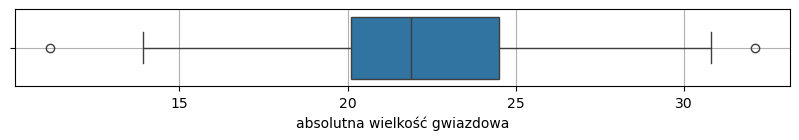

In [14]:
plt.figure(figsize=(10,1))
sns.boxplot(data=df, x=df["absolutna wielkość gwiazdowa"], orient="h")
plt.grid()

Lewy i prawy bok pudełka odpowiadają odpowiednio pierwszemu (25%) i trzeciemu (75%) kwartylowi, natomiast pionowa linia wewnątrz pudełka odpowiada medianie. Po obu stronach każdego pudełka są wąsy, które sięgają w lewo do wartości minimalnej, a w prawo do wartości maksymalnej, po obu stronach z wyłączeniem wartości odstających (outliers). Wartości odstające (outliers) zaznaczone są niewielkimi okręgami po ubu stronach.

Jak wspomniano powyżej, widoczne na powyższym wykresie wartości odstające zostały określone metodą rozstępu międzykwartylowego (interquartile range, IQR). Zakres wąsów na wykresie określony jest w następujący sposób:

- dolna granica = Q1 - 1,5 x IQR
- górna granica = Q3 + 1,5 x IQR

gdzie: 
- Q1 - dolny kwartyl (25%)
- Q3 - górny kwartyl (75%)
- IQR = Q3 - Q1
  
Wartości poza tymi granicami to wartości odstające (outliers).

W przypadku wartości odstających, mamy do wyboru jedno z trzech podejść:
- możemy te wartości po prostu zostawić
- możemy te wartości zastąpić innymi (np. średnią, medianą, granicą wyznaczoną przez kwartyle itp.)
- możemy usunąć wiersze zawierające te wartości

Zanim przejdziemy do analizy wartości odstających dla poszczególnych cech, napiszmy dwie funkcje, które uproszczą nam to zadanie:

- Pierwsza funkcja będzie wyświetlała najważniejsze informacje dotyczące wartości odstających, takie jak kwartyl dolny i górny, rozstęp międzykwartylowy, dolna i górna granica definiująca wartości odstające, liczba wartości odstających poniżej minimum, powyżej maksimum i łącznie. Funkcja będzie także umożliwiała (opcjonalnie) wyświetlenie posortowanych rekordów zawierających wartości odstające.
- Druga funkcja będzie usuwała wiersze z wartościami poza zadanym zakresem. Może to być zakres obejmujący wartości odstające, ale może to być także dowolny inaczej zdefiniowany zakres, gdyż nie zawsze będziemy chcieli usuwać wszystkie wiersze z wartościami odstającymi. Funkcja ta będzie dodatkowo wyświetlać informacje na temat wielkości zbioru przed usunięciem wierszy, liczby usuniętych wierszy oraz wielkości zbioru po usunięciu wierszy.

Definicja pierwszej z opisanych powyżej funkcji wygląda następująco:

In [15]:
def analiza_wartosci_odstajacych(kolumna, niskie=0, wysokie=0, razem=0):
    Q1 = df[kolumna].quantile(.25)
    Q3 = df[kolumna].quantile(.75)
    IQR = Q3 - Q1
    
    dolna_granica = Q1 - 1.5 * IQR
    gorna_granica = Q3 + 1.5 * IQR

    df_odstajace_niskie = df[df[kolumna] < dolna_granica]
    df_odstajace_wysokie = df[df[kolumna] > gorna_granica]
    df_odstajace_razem = pd.concat([df_odstajace_niskie, df_odstajace_wysokie])
    
    liczba_wartosci_odstajacych_niskich = len(df_odstajace_niskie)
    liczba_wartosci_odstajacych_wysokich = len(df_odstajace_wysokie)
    liczba_wartosci_odstajacych = len(df_odstajace_razem)

    zestawienie = f'''
kwartyl dolny: {Q1}
kwartyl górny: {Q3}
rozstęp międzykwartylowy: {IQR}
dolna granica: {dolna_granica}
górna granica: {gorna_granica}
liczba wartości odstających poniżej minimum: {liczba_wartosci_odstajacych_niskich}
liczba wartości odstających powyżej maksimum: {liczba_wartosci_odstajacych_wysokich}
liczba wartości odstających łącznie: {liczba_wartosci_odstajacych}
'''
    
    print(zestawienie)
    
    if niskie > 0:
        print(f'Wartości odstające poniżej minimum (liczba rekordów: {niskie}):\n')
        print(df_odstajace_niskie.sort_values(by=kolumna).head(niskie))

    if wysokie > 0:
        print(f'Wartości odstające powyżej maksimum (liczba rekordów: {wysokie}):\n')
        print(df_odstajace_wysokie.sort_values(by=kolumna).head(wysokie))

    if razem > 0:
        print(f'Wartości odstające (liczba rekordów: {razem}):\n')
        print(df_odstajace_razem.sort_values(by=kolumna).head(razem))

Definicja drugiej funkcji wygląda tak:

In [16]:
def usun_rekordy_spoza_zakresu(df, kolumna, zakres_dolny, zakres_gorny):
    rekordy_przed = len(df)
    df = df[(df[kolumna] >= zakres_dolny) & (df[kolumna] <= zakres_gorny)]
    rekordy_po = len(df)
    print(f'Liczba rekordów przed usunięciem wartości spoza podanego zakresu: {rekordy_przed}')
    print(f'Liczba usuniętych rekordów: {rekordy_przed - rekordy_po}')
    print(f'Liczba pozostałych rekordów: {rekordy_po}')
    return df

Teraz możemy rozpocząć analizę wartości odstających dla poszczególnych cech.

##### absolutna wielkość gwiazdowa

Wykres pudełkowy dla cechy absolutna wielkość gwiazdowa przedstawia się następująco:

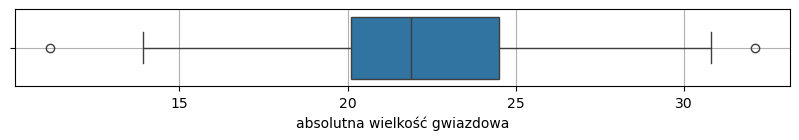

In [17]:
plt.figure(figsize=(10, 1))
sns.boxplot(data=df, x=df["absolutna wielkość gwiazdowa"], orient="h")
plt.grid()

W rozbiciu na poszczególne wartości cechy docelowej (zagrożenie) wygląda to tak:

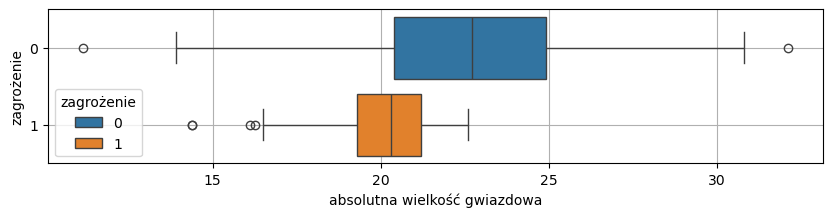

In [18]:
plt.figure(figsize=(10, 2))
sns.boxplot(data=df, x=df["absolutna wielkość gwiazdowa"], y=df["zagrożenie"], hue="zagrożenie", orient="h")
plt.grid()

Jak widać na powyższym wykresie, mamy tu wartości odstające (outliers) poniżej wartości minimalnej dla obiektów zagrażających i niezagrażających oraz wartości odstające powyżej wartości maksymalnej dla obiektów niezagrażających. Musimy zdecydować, czy pozostawimy je w zbiorze, zastąpimy innymi wartościami, czy usuniemy. W tym przypadku wartości odstające nie wykraczają poza realny zakres wartości dla tej cechy i nie odbiegają od wartości minimalnych i maksymalnych w sposób drastyczny, dlatego dla cechy absolutna wielkość gwiazdowa, wartości odstających nie będziemy usuwać.

##### średnica min km

Wykres pudełkowy dla cechy średnica min km przedstawia się następująco:

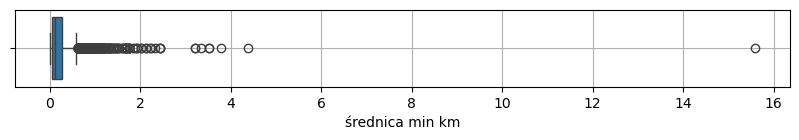

In [19]:
plt.figure(figsize=(10, 1))
sns.boxplot(data=df, x=df["średnica min km"], orient="h")
plt.grid()

W rozbiciu na poszczególne wartości cechy docelowej (zagrożenie) wygląda to tak:

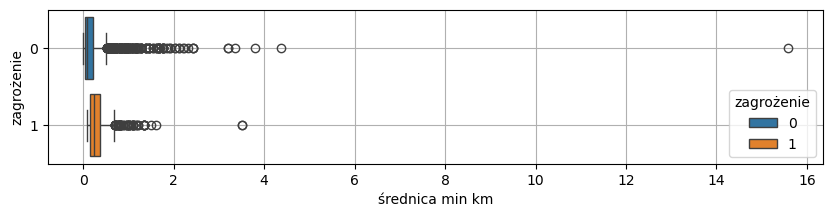

In [20]:
plt.figure(figsize=(10, 2))
sns.boxplot(data=df, x=df["średnica min km"], y=df["zagrożenie"], hue="zagrożenie", orient="h")
plt.grid()

Jak widać na powyższym wykresie, mamy tu wartości odstające (outliers) powyżej wartości maksymalnej. Niektóre z nich bardzo mocno odstają od wartości maksymalnej. Na wykresie widać, że większość wartości odstających nie przekracza wartości 3. Sprawdźmy, ile jest wartości odstających wyższych niż 3:

In [21]:
len(df[df["średnica min km"] > 3])

8

Jest ich tylko 8, więc możemy je usunąć ze zbioru. Wykorzystamy do tego jedną ze zdefiniowanych wcześniej funkcji:

In [22]:
df = usun_rekordy_spoza_zakresu(df, 'średnica min km', 0, 3)

Liczba rekordów przed usunięciem wartości spoza podanego zakresu: 4687
Liczba usuniętych rekordów: 8
Liczba pozostałych rekordów: 4679


Sprawdźmy jak teraz wygląda rozkład wartości odstających:

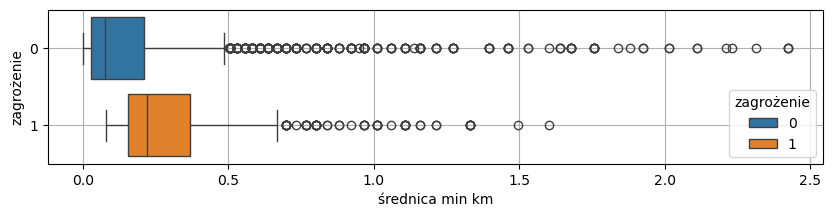

In [23]:
plt.figure(figsize=(10, 2))
sns.boxplot(data=df, x=df["średnica min km"], y=df["zagrożenie"], hue="zagrożenie", orient="h")
plt.grid()

Pozostałe wartości odstające znajdują się stosunkowo blisko wartości maksymalnej i nie będziemy ich usuwać.

##### średnica max km

Wykres pudełkowy dla cechy średnica max km przedstawia się następująco:

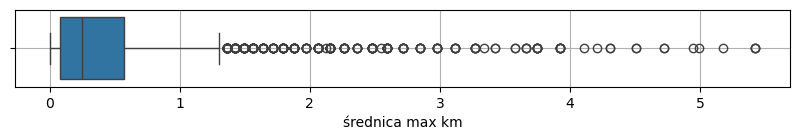

In [24]:
plt.figure(figsize=(10, 1))
sns.boxplot(data=df, x=df["średnica max km"], orient="h")
plt.grid()

W rozbiciu na poszczególne wartości cechy docelowej (zagrożenie) wygląda to tak:

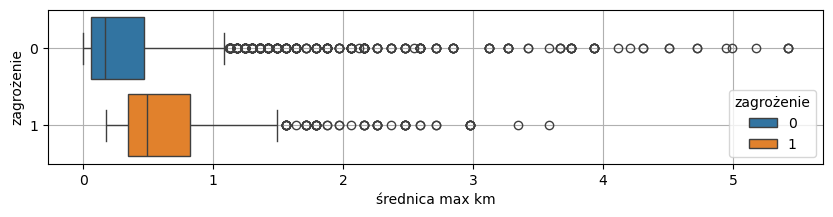

In [25]:
plt.figure(figsize=(10, 2))
sns.boxplot(data=df, x=df["średnica max km"], y=df["zagrożenie"], hue="zagrożenie", orient="h")
plt.grid()

Wcześniej widzieliśmy, że największy obiekt miał wartość ok. 34,84 km dla tej cechy. Obiektu tego nie widać na powyższym wykresie, co oznacza, że został usunięty podczas usuwania 8 wartości odstających w poprzednim kroku. Wiemy też, że 75% obiektów ma średnicę maksymalną do ok. 0,57 km, więc obiekt ten i tak odstawałby znacząco od pozostałych i zostałby usunięty.

W teh chwili dla cechy średnica max km mamy wartości odstające powyżej wartości maksymalnej, ale nie odstają one w sposób znaczący, dlatego zostawimy je w zbiorze.

##### prędkość kmh

Wykres pudełkowy dla cechy prędkość kmh przedstawia się następująco:

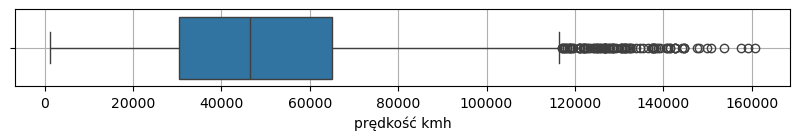

In [26]:
plt.figure(figsize=(10, 1))
sns.boxplot(data=df, x=df["prędkość kmh"], orient="h")
plt.grid()

W rozbiciu na poszczególne wartości cechy docelowej (zagrożenie) wygląda to tak:

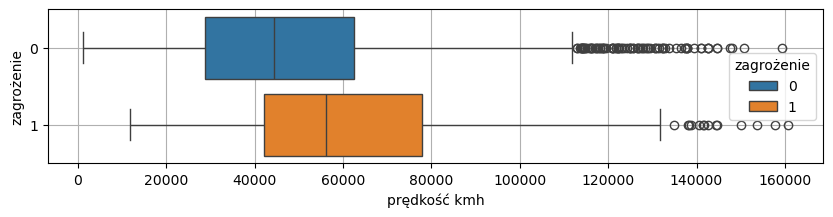

In [27]:
plt.figure(figsize=(10, 2))
sns.boxplot(data=df, x=df["prędkość kmh"], y=df["zagrożenie"], hue="zagrożenie", orient="h")
plt.grid()

Mamy tu wartości odstające (outliers) powyżej wartości maksymalnej, ale nie wykraczają one znacząco poza wartość maksymalną, dlatego dla cechy prędkość kmh, wartości odstających nie będziemy usuwać.

##### min odległość od Ziemi km

Wykres pudełkowy dla cechy min odległość od Ziemi km przedstawia się następująco:

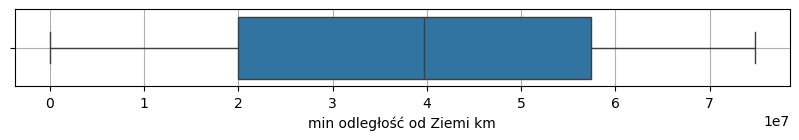

In [28]:
plt.figure(figsize=(10, 1))
sns.boxplot(data=df, x=df["min odległość od Ziemi km"], orient="h")
plt.grid()

W rozbiciu na poszczególne wartości cechy docelowej (zagrożenie) wygląda to tak:

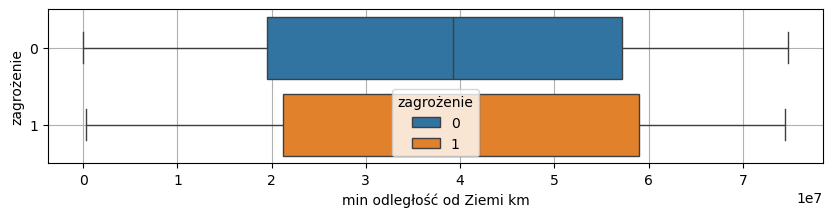

In [29]:
plt.figure(figsize=(10, 2))
sns.boxplot(data=df, x=df["min odległość od Ziemi km"], y=df["zagrożenie"], hue="zagrożenie", orient="h")
plt.grid()

Dla cechy min odległość od Ziemi km nie mamy wartości odstających. 

##### niepewność orbity

Wykres pudełkowy dla cechy niepewność orbity przedstawia się następująco:

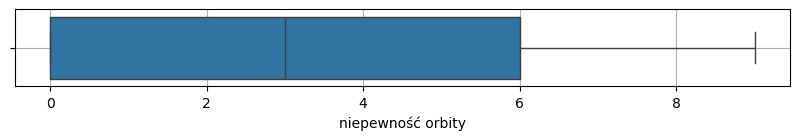

In [30]:
plt.figure(figsize=(10, 1))
sns.boxplot(data=df, x=df["niepewność orbity"], orient="h")
plt.grid()

W rozbiciu na poszczególne wartości cechy docelowej (zagrożenie) wygląda to tak:

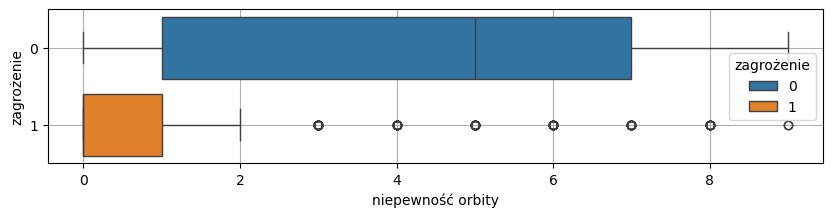

In [31]:
plt.figure(figsize=(10, 2))
sns.boxplot(data=df, x=df["niepewność orbity"], y=df["zagrożenie"], hue="zagrożenie", orient="h")
plt.grid()

Mamy tu wartości odstające (outliers) powyżej wartości maksymalnej dla obiektów zagrażających. W ujęciu sumarycznym nie mamy wartości odstających. Dla cechy niepewność orbity wartości odstających nie będziemy usuwać.

##### min odległość orbit

Wykres pudełkowy dla cechy min odległość orbit przedstawia się następująco:

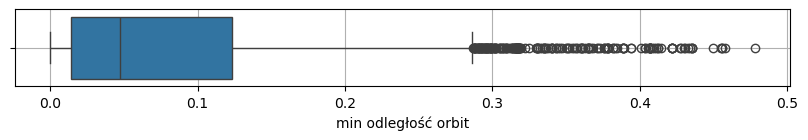

In [32]:
plt.figure(figsize=(10, 1))
sns.boxplot(data=df, x=df["min odległość orbit"], orient="h")
plt.grid()

W rozbiciu na poszczególne wartości cechy docelowej (zagrożenie) wygląda to tak:

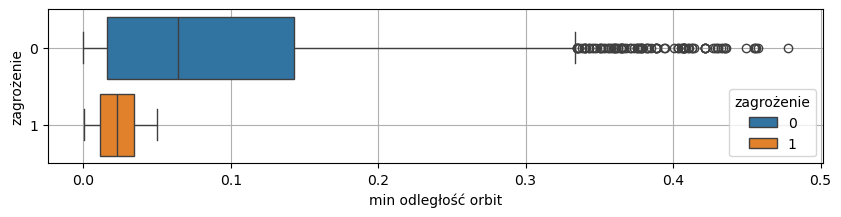

In [33]:
plt.figure(figsize=(10, 2))
sns.boxplot(data=df, x=df["min odległość orbit"], y=df["zagrożenie"], hue="zagrożenie", orient="h")
plt.grid()

Jak widać na powyższym wykresie, mamy tu wartości odstające (outliers) powyżej wartości maksymalnej, ale znajdują się one w miarę blisko tej wartości, dlatego dla cechy min odległość orbit, wartości odstających nie będziemy usuwać.

##### niezmiennik Tisseranda względem Jowisza

Wykres pudełkowy dla cechy niezmiennik Tisseranda względem Jowisza przedstawia się następująco:

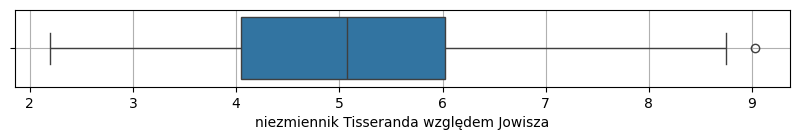

In [34]:
plt.figure(figsize=(10, 1))
sns.boxplot(data=df, x=df["niezmiennik Tisseranda względem Jowisza"], orient="h")
plt.grid()

W rozbiciu na poszczególne wartości cechy docelowej (zagrożenie) wygląda to tak:

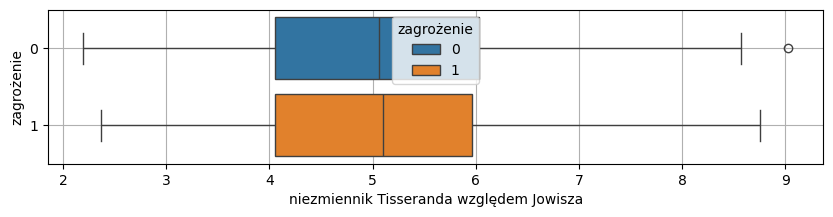

In [35]:
plt.figure(figsize=(10, 2))
sns.boxplot(data=df, x=df["niezmiennik Tisseranda względem Jowisza"], y=df["zagrożenie"], hue="zagrożenie", orient="h")
plt.grid()

Mamy tu wartości odstające (outliers) powyżej wartości maksymalnej, ale stosunkowo blisko tej wartości, dlatego dla cechy niezmiennik Tisseranda względem Jowisza, wartości odstających nie będziemy usuwać.

##### oskulacja epokowa

Wykres pudełkowy dla cechy oskulacja epokowa przedstawia się następująco:

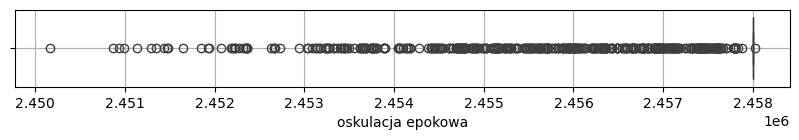

In [36]:
plt.figure(figsize=(10, 1))
sns.boxplot(data=df, x=df["oskulacja epokowa"], orient="h")
plt.grid()

W rozbiciu na poszczególne wartości cechy docelowej (zagrożenie) wygląda to tak:

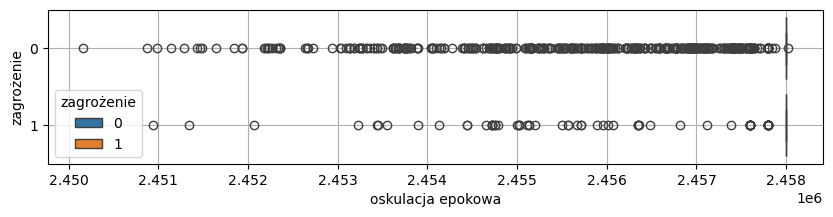

In [37]:
plt.figure(figsize=(10, 2))
sns.boxplot(data=df, x=df["oskulacja epokowa"], y=df["zagrożenie"], hue="zagrożenie", orient="h")
plt.grid()

Mamy tu bardzo dużo wartości odstających. Korzystając ze zdefiniowanej powyżej funkcji, przeprowadźmy ich analizę:

In [38]:
analiza_wartosci_odstajacych('oskulacja epokowa', niskie=0, wysokie=0, razem=0)


kwartyl dolny: 2458000.5
kwartyl górny: 2458000.5
rozstęp międzykwartylowy: 0.0
dolna granica: 2458000.5
górna granica: 2458000.5
liczba wartości odstających poniżej minimum: 637
liczba wartości odstających powyżej maksimum: 1
liczba wartości odstających łącznie: 638



Tylko jedna wartość odstająca znajduje się powyżej maksimum. W dolnym zakresie mamy natomiast aż 638 wartości odstających. W stosunku do wielkości naszego zbioru jest to liczba znacząca i usunięcie tylu wierszy mogłoby nas pozbawić wielu innych cennych infirmacji w nich zawartych. Dlatego nie będziemy tych wartości usuwać. W dalszej części analizy dokonamy zabadamy korelację tej cechy z cechą docelową i jeśli będzie ona bardzo słaba, usuniemy tą cechę całkowicie.

##### ekscentryczność

Wykres pudełkowy dla cechy ekscentryczność przedstawia się następująco:

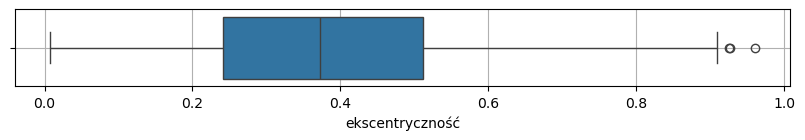

In [39]:
plt.figure(figsize=(10, 1))
sns.boxplot(data=df, x=df["ekscentryczność"], orient="h")
plt.grid()

W rozbiciu na poszczególne wartości cechy docelowej (zagrożenie) wygląda to tak:

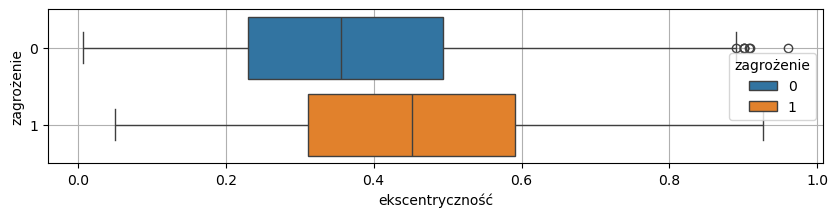

In [40]:
plt.figure(figsize=(10, 2))
sns.boxplot(data=df, x=df["ekscentryczność"], y=df["zagrożenie"], hue="zagrożenie", orient="h")
plt.grid()

Jak widać na powyższym wykresie, mamy tu wartości odstające (outliers) powyżej wartości maksymalnej, ale znajdują się one bardzo blisko tej wartości, dlatego dla cechy ekscentryczność, wartości odstających nie będziemy usuwać.

##### półoś wielka

Wykres pudełkowy dla cechy półoś wielka przedstawia się następująco:

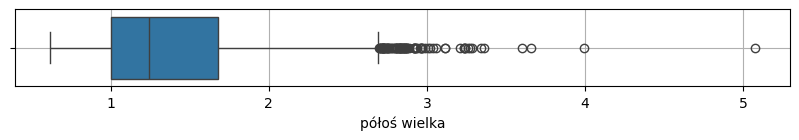

In [41]:
plt.figure(figsize=(10, 1))
sns.boxplot(data=df, x=df["półoś wielka"], orient="h")
plt.grid()

W rozbiciu na poszczególne wartości cechy docelowej (zagrożenie) wygląda to tak:

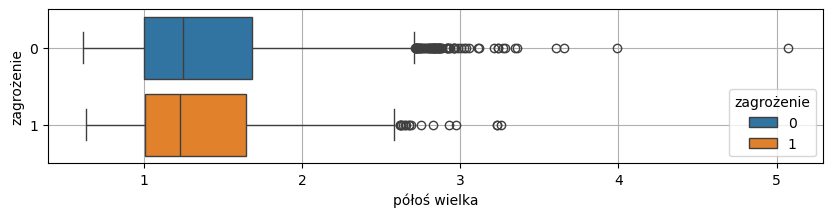

In [42]:
plt.figure(figsize=(10, 2))
sns.boxplot(data=df, x=df["półoś wielka"], y=df["zagrożenie"], hue="zagrożenie", orient="h")
plt.grid()

Mamy tu wartości odstające (outliers) powyżej wartości maksymalnej. Część z nich odstaje w sposób znaczący od tej wartości. Na wykresie widzimy, że dotyczy to głównie wartości wyższych niż 3,5. Sprawdźmy ile ich jest w zbiorze:

In [43]:
len(df[df["półoś wielka"] > 3.5])

4

Jest to znikoma liczba, więc możemy usunąć wiersze zawierające te wartości:

In [44]:
df = usun_rekordy_spoza_zakresu(df, 'półoś wielka', 0, 3.5)

Liczba rekordów przed usunięciem wartości spoza podanego zakresu: 4679
Liczba usuniętych rekordów: 4
Liczba pozostałych rekordów: 4675


Pozostałe wartości odstające zostawimy.

##### inklinacja

Wykres pudełkowy dla cechy inklinacja przedstawia się następująco:

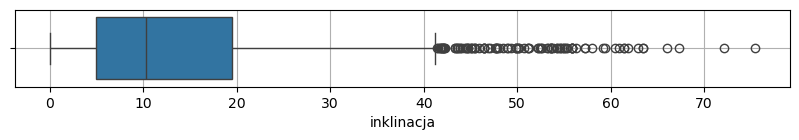

In [45]:
plt.figure(figsize=(10, 1))
sns.boxplot(data=df, x=df["inklinacja"], orient="h")
plt.grid()

W rozbiciu na poszczególne wartości cechy docelowej (zagrożenie) wygląda to tak:

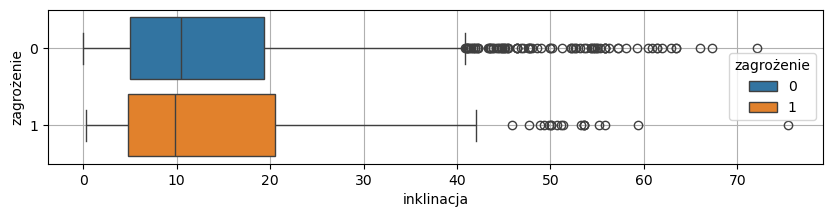

In [46]:
plt.figure(figsize=(10, 2))
sns.boxplot(data=df, x=df["inklinacja"], y=df["zagrożenie"], hue="zagrożenie", orient="h")
plt.grid()

Jak widać na powyższym wykresie, mamy tu wartości odstające (outliers) powyżej wartości maksymalnej, ale nie wykraczają one znacząco poza tą wartość, dlatego dla cechy inklinacja, wartości odstających nie będziemy usuwać.

##### długość węzła wstępującego

Wykres pudełkowy dla cechy długość węzła wstępującego przedstawia się następująco:

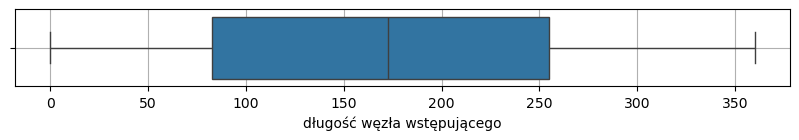

In [47]:
plt.figure(figsize=(10, 1))
sns.boxplot(data=df, x=df["długość węzła wstępującego"], orient="h")
plt.grid()

W rozbiciu na poszczególne wartości cechy docelowej (zagrożenie) wygląda to tak:

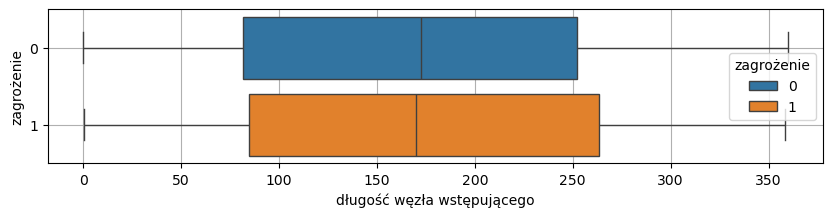

In [48]:
plt.figure(figsize=(10, 2))
sns.boxplot(data=df, x=df["długość węzła wstępującego"], y=df["zagrożenie"], hue="zagrożenie", orient="h")
plt.grid()

Dla cechy długość węzła wstępującego nie ma wartości odstających.

##### okres orbitalny

Wykres pudełkowy dla cechy okres orbitalny przedstawia się następująco:

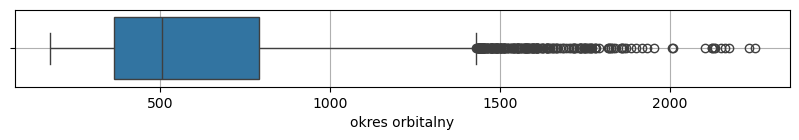

In [49]:
plt.figure(figsize=(10, 1))
sns.boxplot(data=df, x=df["okres orbitalny"], orient="h")
plt.grid()

W rozbiciu na poszczególne wartości cechy docelowej (zagrożenie) wygląda to tak:

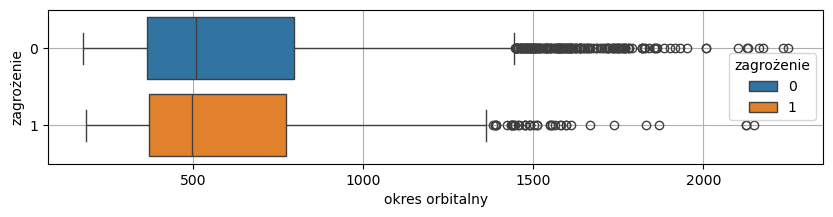

In [50]:
plt.figure(figsize=(10, 2))
sns.boxplot(data=df, x=df["okres orbitalny"], y=df["zagrożenie"], hue="zagrożenie", orient="h")
plt.grid()

Jak widać na powyższym wykresie, mamy tu wartości odstające (outliers) powyżej wartości maksymalnej, ale nie wykraczają one znacząco poza tą wartość, dlatego dla cechy okres orbitalny, wartości odstających nie będziemy usuwać.

##### odległość peryhelium

Wykres pudełkowy dla cechy odległość peryhelium przedstawia się następująco:

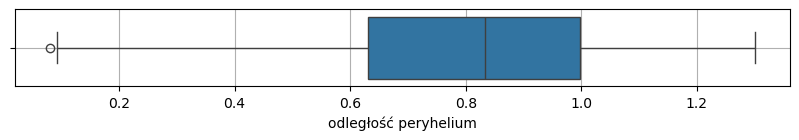

In [51]:
plt.figure(figsize=(10, 1))
sns.boxplot(data=df, x=df["odległość peryhelium"], orient="h")
plt.grid()

W rozbiciu na poszczególne wartości cechy docelowej (zagrożenie) wygląda to tak:

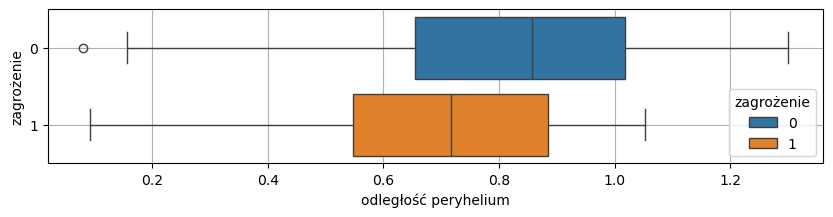

In [52]:
plt.figure(figsize=(10, 2))
sns.boxplot(data=df, x=df["odległość peryhelium"], y=df["zagrożenie"], hue="zagrożenie", orient="h")
plt.grid()

Dla cechy odległość peryhelium wartości odstające są nieliczne i znajdują się tylko nieco poniżej wartości minimalnej, dlatego nie będziemy usuwać.

##### argument peryhelium

Wykres pudełkowy dla cechy argument peryhelium przedstawia się następująco:

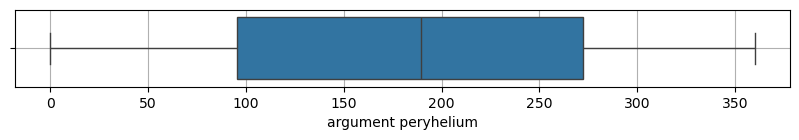

In [53]:
plt.figure(figsize=(10, 1))
sns.boxplot(data=df, x=df["argument peryhelium"], orient="h")
plt.grid()

W rozbiciu na poszczególne wartości cechy docelowej (zagrożenie) wygląda to tak:

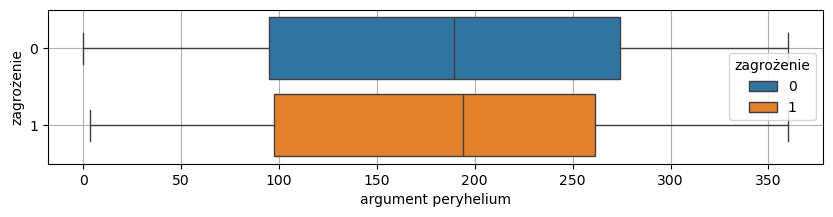

In [54]:
plt.figure(figsize=(10, 2))
sns.boxplot(data=df, x=df["argument peryhelium"], y=df["zagrożenie"], hue="zagrożenie", orient="h")
plt.grid()

Dla cechy argument peryhelium nie mamy wartości odstających.

##### odległość aphelium

Wykres pudełkowy dla cechy odległość aphelium przedstawia się następująco:

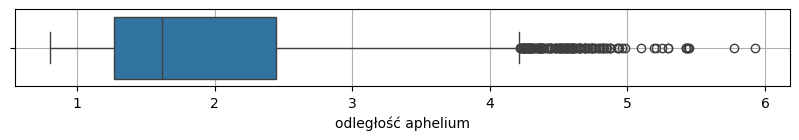

In [55]:
plt.figure(figsize=(10, 1))
sns.boxplot(data=df, x=df["odległość aphelium"], orient="h")
plt.grid()

W rozbiciu na poszczególne wartości cechy docelowej (zagrożenie) wygląda to tak:

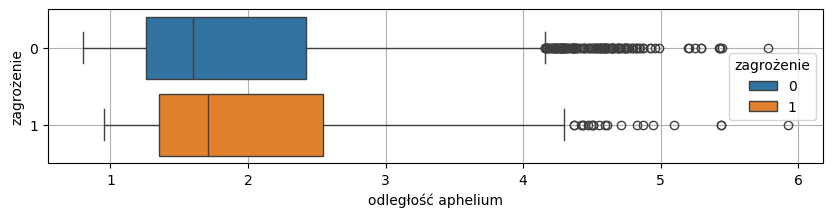

In [56]:
plt.figure(figsize=(10, 2))
sns.boxplot(data=df, x=df["odległość aphelium"], y=df["zagrożenie"], hue="zagrożenie", orient="h")
plt.grid()

Jak widać na powyższym wykresie, mamy tu wartości odstające (outliers) powyżej wartości maksymalnej, ale stosunkowo blisko tej wartości, dlatego dla cechy odległość aphelium, wartości odstających nie będziemy usuwać.

##### anomalia średnia

Wykres pudełkowy dla cechy anomalia średnia przedstawia się następująco:

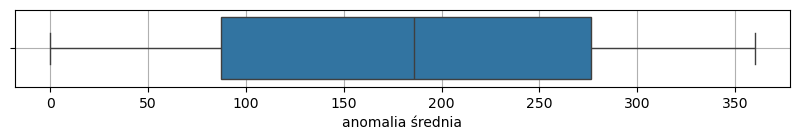

In [57]:
plt.figure(figsize=(10, 1))
sns.boxplot(data=df, x=df["anomalia średnia"], orient="h")
plt.grid()

W rozbiciu na poszczególne wartości cechy docelowej (zagrożenie) wygląda to tak:

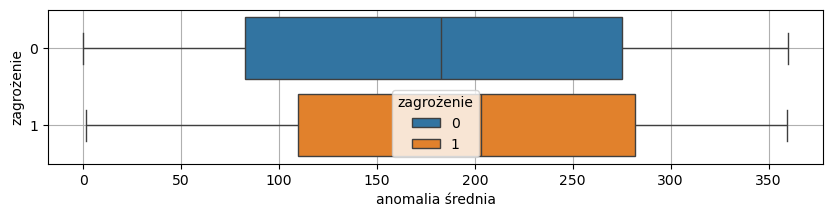

In [58]:
plt.figure(figsize=(10, 2))
sns.boxplot(data=df, x=df["anomalia średnia"], y=df["zagrożenie"], hue="zagrożenie", orient="h")
plt.grid()

Dla cechy anomalia średnia nie mamy wartości odstających.

##### średnia prędkość kątowa

Wykres pudełkowy dla cechy średnia prędkość kątowa przedstawia się następująco:

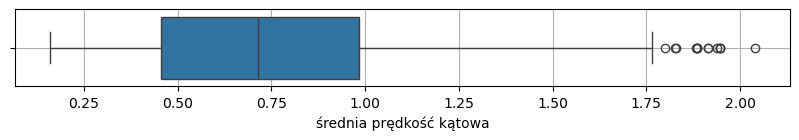

In [59]:
plt.figure(figsize=(10, 1))
sns.boxplot(data=df, x=df["średnia prędkość kątowa"], orient="h")
plt.grid()

W rozbiciu na poszczególne wartości cechy docelowej (zagrożenie) wygląda to tak:

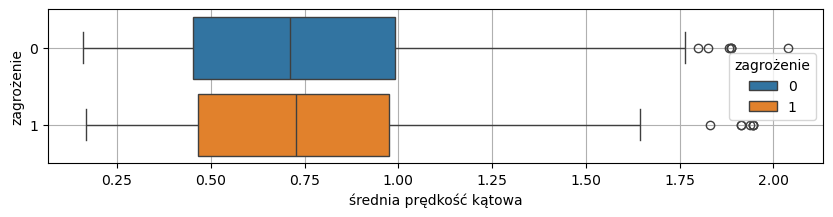

In [60]:
plt.figure(figsize=(10, 2))
sns.boxplot(data=df, x=df["średnia prędkość kątowa"], y=df["zagrożenie"], hue="zagrożenie", orient="h")
plt.grid()

Mamy tu wartości odstające (outliers) powyżej wartości maksymalnej, ale tylko nieznacznie powyżej tej wartości, dlatego dla cechy średnia prędkość kątowa, wartości odstających nie będziemy usuwać.

Przyjrzyjmy się statystykom naszego zbioru po usunięciu części wartości odstających:

In [61]:
df.describe()

,absolutna wielkość gwiazdowa,średnica min km,średnica max km,prędkość kmh,min odległość od Ziemi km,niepewność orbity,min odległość orbit,niezmiennik Tisseranda względem Jowisza,oskulacja epokowa,ekscentryczność,półoś wielka,inklinacja,długość węzła wstępującego,okres orbitalny,odległość peryhelium,argument peryhelium,odległość aphelium,anomalia średnia,średnia prędkość kątowa,zagrożenie
count,4675.000000,4675.000000,4675.000000,4675.000000,4.675000e+03,4675.000000,4675.000000,4675.000000,4.675000e+03,4675.000000,4675.000000,4675.000000,4675.000000,4675.000000,4675.000000,4675.000000,4675.000000,4675.000000,4675.000000,4675.000000
mean,22.282925,0.196338,0.439025,50257.036718,3.839222e+07,3.520214,0.082187,5.058949,2.457724e+06,0.382084,1.397713,13.365377,172.057800,633.359371,0.813243,183.946046,1.982183,181.245887,0.738887,0.161070
std,2.873700,0.263112,0.588336,26241.442624,2.182143e+07,3.077060,0.090278,1.235366,9.197665e+02,0.180221,0.518165,10.935481,103.280313,363.899356,0.241907,103.609806,0.939666,107.404509,0.342144,0.367634
min,15.200000,0.001011,0.002260,1207.814804,2.660989e+04,0.000000,0.000002,2.196000,2.450164e+06,0.007522,0.615920,0.014513,0.001941,176.557161,0.080744,0.006918,0.803765,0.003191,0.160096,0.000000
25%,20.100000,0.033462,0.074824,30329.146070,1.993892e+07,0.000000,0.014520,4.053000,2.458000e+06,0.240645,1.000635,4.932691,82.674124,365.605031,0.630834,95.447813,1.266059,87.104049,0.455090,0.000000
50%,21.900000,0.110804,0.247765,46503.384792,3.961691e+07,3.000000,0.046968,5.075000,2.458000e+06,0.372183,1.240404,10.297333,172.585405,504.595144,0.833153,189.772884,1.617976,185.792049,0.713443,0.000000
75%,24.500000,0.253837,0.567597,65021.819626,5.746863e+07,6.000000,0.122189,6.021500,2.458000e+06,0.512286,1.673932,19.500637,254.712449,791.052516,0.997053,272.261273,2.446503,276.531946,0.984669,0.000000
max,32.100000,2.424125,5.420508,160681.487851,7.478160e+07,9.000000,0.477891,9.025000,2.458020e+06,0.960261,3.359049,75.406667,359.905890,2248.655832,1.299832,359.993098,5.924213,359.917991,2.039000,1.000000


W tej chwili wartości dla poszczególnych cech są bardziej realne niż przed usunięciem niektórych rekordów zawierających wartości odstające.

#### Korelacje między cechami

Zanim przejdziemy do szczegółowej analizy poszczególnych cech, przyjrzyjmy się temu, w jaki sposób cechy te są ze sobą powiązane. Przede wszystkim zwróćmy uwagę na korelacje z cechą zagrożenie, która jest cechą docelową:

In [62]:
df_corr = df.corr()
df_corr

,absolutna wielkość gwiazdowa,średnica min km,średnica max km,prędkość kmh,min odległość od Ziemi km,niepewność orbity,min odległość orbit,niezmiennik Tisseranda względem Jowisza,oskulacja epokowa,ekscentryczność,półoś wielka,inklinacja,długość węzła wstępującego,okres orbitalny,odległość peryhelium,argument peryhelium,odległość aphelium,anomalia średnia,średnia prędkość kątowa,zagrożenie
absolutna wielkość gwiazdowa,1.000000,-0.768095,-0.768095,-0.377385,-0.339705,0.678479,-0.490660,0.239178,-0.117988,-0.361545,-0.213846,-0.463360,-0.009425,-0.209436,0.086941,0.031366,-0.258227,-0.049479,0.195927,-0.327441
średnica min km,-0.768095,1.000000,1.000000,0.340782,0.248277,-0.526443,0.349437,-0.178382,0.088368,0.300982,0.165760,0.367797,0.029870,0.164555,-0.107998,-0.023517,0.210615,0.049054,-0.136858,0.185663
średnica max km,-0.768095,1.000000,1.000000,0.340782,0.248277,-0.526443,0.349437,-0.178382,0.088368,0.300982,0.165760,0.367797,0.029870,0.164555,-0.107998,-0.023517,0.210615,0.049054,-0.136858,0.185663
prędkość kmh,-0.377385,0.340782,0.340782,1.000000,0.352514,-0.201871,0.076623,-0.050640,0.020161,0.494334,0.011890,0.515438,-0.020783,0.015438,-0.507815,-0.003155,0.143844,0.016728,0.024082,0.191372
min odległość od Ziemi km,-0.339705,0.248277,0.248277,0.352514,1.000000,-0.326501,0.351646,0.094986,0.193750,-0.006216,-0.115271,0.255808,-0.023391,-0.114227,-0.080810,-0.021194,-0.106325,-0.010409,0.105502,0.032676
niepewność orbity,0.678479,-0.526443,-0.526443,-0.201871,-0.326501,1.000000,-0.268771,-0.007598,-0.332479,-0.088846,0.040018,-0.230182,-0.009353,0.042493,0.106405,0.016002,0.016741,-0.057975,-0.022640,-0.328843
min odległość orbit,-0.490660,0.349437,0.349437,0.076623,0.351646,-0.268771,1.000000,-0.305311,0.081170,0.092756,0.288145,0.439306,-0.009525,0.279811,0.299061,-0.029209,0.240797,-0.012093,-0.290095,-0.288426
niezmiennik Tisseranda względem Jowisza,0.239178,-0.178382,-0.178382,-0.050640,0.094986,-0.007598,-0.305311,1.000000,0.050666,-0.476715,-0.933431,-0.035994,0.019872,-0.900780,-0.537232,0.064988,-0.891149,0.030640,0.992709,-0.003029
oskulacja epokowa,-0.117988,0.088368,0.088368,0.020161,0.193750,-0.332479,0.081170,0.050666,1.000000,-0.067111,-0.056623,0.015469,0.018599,-0.055100,0.000482,-0.007174,-0.062572,0.035177,0.045358,0.040483
ekscentryczność,-0.361545,0.300982,0.300982,0.494334,-0.006216,-0.088846,0.092756,-0.476715,-0.067111,1.000000,0.540103,0.038174,-0.015822,0.549414,-0.415212,-0.003363,0.702556,0.026840,-0.393300,0.183528


Widoczne tu wartości przyjmują wartości od -1 do 1, przy czym wartości te oznaczają odpowiednio:
- wartość równa 1 - całkowita korelacja dodatnia (czyli gdy wartość jednej cechy rośnie, wartość drugiej cechy także rośnie dokładnie tak samo)
- czym wartość jest bliższa 1, tym mocniejsza jest korelacja dodatnia (czyli gdy wartość jednej cechy rośnie, wartość drugiej cechy także rośnie)
- czym wartość jest bliższa -1, tym mocniejsza jest korelacja ujemna (czyli gdy wartość jednej cechy rośnie, wartość drugiej cechy maleje)
- czym wartość jest bliższa 0, tym słabsza jest korelacja między wartościami obu cech - może być lekko dodatnia lub lekko ujemna
- wartość równa -1 - całkowita korelacja ujemna (czyli gdy wartość jednej cechy rośnie, wartość drugiej cechy także rośnie dokładnie tak samo w drugą stronę)

Korelacje pomiędzy dwoma cechami odczytujemy na ich przecięciu. Na przecięciach tej samej cechy (np. wiersza inklinacja i kolumny inklinacja) korelacja zawsze wynosi 1. 

Przykładowo przyjrzyjmy się korelacji pomiędzy cechami absolutna wielkość gwiazdowa i średnica max km. Na przecięciu tych cech jest wartość -0.768095, co oznacza mocną korelację ujemną. Wraz ze wzrostem absolutnej wielkości gwiazdowej, średnica maksymalna obiektu jest coraz mniejsza. W tym przypadku jest to intuicyjne: im mniejszy obiekt, tym mniejszą ma jasność, a mniejsza jasność oznacza wyższą absolutną wielkość gwiazdową.

Takie przedstawienie korelacji może być mało czytelne przy dużej liczbie cech. Bardziej czytelne dla ludzkiego oka jest przedstawienie korelacji w sposób graficzny za pomocą heatmapy, czyli mapy ciepła (heatmap), gdzie do poszczególnych wartości przypisane są odpowiednie kolory. Heatmapę możemy sporządzić za pomocą funkcji heatmap z bibioteki seaborn:

<Axes: title={'center': 'Macierz korelacji'}>

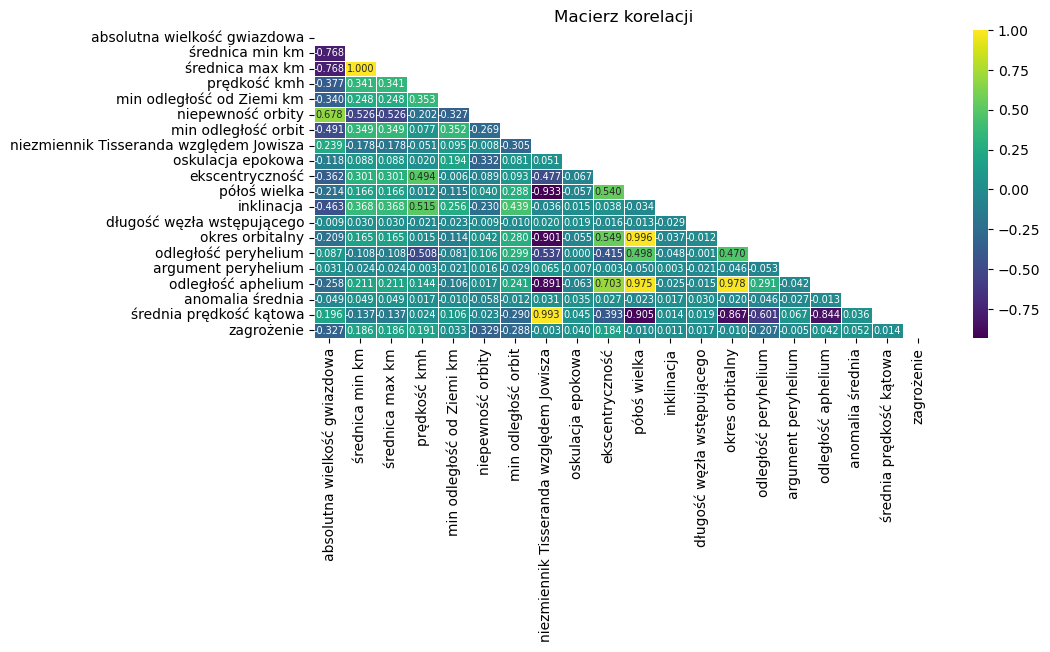

In [63]:
mask = np.triu(df_corr)
plt.figure(figsize = (10, 4))
plt.title("Macierz korelacji")
sns.heatmap(df_corr, 
            cmap = 'viridis', 
            annot = True, 
            annot_kws={"size": 7}, 
            mask = mask, linecolor = 'white', 
            linewidth = .5, 
            fmt = '.3f')

Użyliśmy tu maski w celu ukrycia górnej połowy macierzy, gdzie wartości się powtarzają. Po prawej stronie widzimy mapę kolorów użytych w heatmapie. Wartości wyświetlone są z dokładnością do 3 miejsc po przecinku.

Dzięki użyciu kolorów, od razu widać, które cechy są ze sobą skorelowane w jakim stopniu. Dla większości par mamy słabą korelację dodatnią lub ujemną. Najbardziej dodatnio skorelowane są ze sobą następujące pary cech:

- średnica max km i średnica min km (1,000)
- okres orbitalny i półoś wielka (0,996)
- średnia prędkość kątowa i niezmiennik Tisseranda względem Jowisza (0,993)
- odległość aphelium i okres orbitalny (0,978)
- odległość aphelium i półoś wielka (0,975)

Najbardziej ujemnie skorelowane są ze sobą następujące pary cech:
- półoś wielka i niezmiennik Tisseranda względem Jowisza (-0,933)
- średnia prędkość kątowa i półoś wielka (-0,905)
- okres orbitalny i niezmiennik Tisseranda względem Jowisza (-0,901)
- odległość aphelium i niezmiennik Tisseranda względem Jowisza (-0,891)
- średnia prędkość kątowa i okres orbitalny (-0.867)
- średnia prędkość kątowa i odległość aphelium (-0.844)

Dla wielu innych par wartości absolutne korelacji są wyższe niż 0,6, czyli są to korelacje mocne.

W przypadku bardzo mocno skorelowanych cech, mamy do czynienia z kolinearnością cech, która może negatywnie wpłynąć na modele uczenia maszynowego, dlatego zalecane jest usunięcie jednej cechy w każdej takiej parze. Silnie skorelowane cechy wnoszą taką samą informację o danych, więc nie ma potrzeby ich dublowania.

Usuniemy po jednej cesze we wszystkich parach, w których wartość bezwzględna korelcji przekracza 0,9. W każdej parze usuniemy tą cechę, która jest trudniejsza od interpretacji, a jeśli obie cechy są porównywalne pod tym względem, usuniemy arbitralnie jedną z nich.

W szczególności dotyczy to następujących cech:
- średnica max km i średnica min km (1,000) - z tej pary usuniemy cechę średnica min km
- okres orbitalny i półoś wielka (0,996) - z tej pary usuniemy cechę półoś wielka
- średnia prędkość kątowa i niezmiennik Tisseranda względem Jowisza (0,993) - z tej pary usuniemy cechę niezmiennik Tisseranda względem Jowisza
- odległość aphelium i okres orbitalny (0,978) - z tej pary usuniemy cechę odległość aphelium
- odległość aphelium i półoś wielka (0,975) - z tej pary obie cechy zostały już usunięte
- półoś wielka i niezmiennik Tisseranda względem Jowisza (-0,933) - z tej pary obie cechy zostały już usunięte
- średnia prędkość kątowa i półoś wielka (-0,905) - z tej pary cecha półoś wielka została już usunięta
- okres orbitalny i niezmiennik Tisseranda względem Jowisza (-0,901) - z tej pary cecha niezmiennik Tisseranda względem Jowisza została już usunięta

Zatem następujące cechy kolinearne usuniemy z naszego zbioru:

In [64]:
cechy_kolinearne = [
    'średnica min km',
    'półoś wielka',
    'niezmiennik Tisseranda względem Jowisza',
    'odległość aphelium'
]

In [65]:
df = df.drop(cechy_kolinearne, axis=1)

Dla nas najistotniejsze są korelacje cechy zagrożenie z pozostałymi cechami. Przyjrzyjmy się tym wartościom, a także wartościom absolutnym korelacji. Ustalmy rodzaj korelacji i jej siłę. Za korelację bardzo słabą przyjmijmy korelację, której wartość absolutna jest poniżej 0,1:

In [66]:
df_corr_bez_kolinearnych = df.corr()
df_corr_zagrożenie = df_corr_bez_kolinearnych['zagrożenie'].sort_values(ascending=False).to_frame().drop(['zagrożenie'])
df_corr_zagrożenie['wartość absolutna korelacji'] = df_corr_zagrożenie.abs()
df_corr_zagrożenie['rodzaj korelacji'] = df_corr_zagrożenie['zagrożenie'].map(np.sign).map({1.0: 'dodatnia', -1.0: 'ujemna'})
df_corr_zagrożenie['korelacja bardzo słaba'] = df_corr_zagrożenie['wartość absolutna korelacji'].map(lambda x: x < 0.1).map({True: 'tak', False: 'nie'})
df_corr_zagrożenie

,zagrożenie,wartość absolutna korelacji,rodzaj korelacji,korelacja bardzo słaba
prędkość kmh,0.191372,0.191372,dodatnia,nie
średnica max km,0.185663,0.185663,dodatnia,nie
ekscentryczność,0.183528,0.183528,dodatnia,nie
anomalia średnia,0.052333,0.052333,dodatnia,tak
oskulacja epokowa,0.040483,0.040483,dodatnia,tak
min odległość od Ziemi km,0.032676,0.032676,dodatnia,tak
długość węzła wstępującego,0.016620,0.016620,dodatnia,tak
średnia prędkość kątowa,0.013564,0.013564,dodatnia,tak
inklinacja,0.010682,0.010682,dodatnia,tak
argument peryhelium,-0.004519,0.004519,ujemna,tak


Jak widać, w 8 przypadkach korelacja jest bardzo słaba. Dotyczy to korelacji z cechami anomalia średnia, oskulacja epokowa, min odległość od Ziemi km, długość węzła wstępującego, średnia prędkość kątowa, inklinacja, argument peryhelium i okres orbitalny. W związku z tym, usuniemy te cechy z dalszej analizy:

In [67]:
df = df.drop([
    'anomalia średnia', 
    'oskulacja epokowa', 
    'min odległość od Ziemi km', 
    'długość węzła wstępującego', 
    'średnia prędkość kątowa', 
    'inklinacja', 
    'argument peryhelium', 
    'okres orbitalny'
], axis=1)

In [68]:
df.head()

,absolutna wielkość gwiazdowa,średnica max km,prędkość kmh,niepewność orbity,min odległość orbit,ekscentryczność,odległość peryhelium,zagrożenie
0,21.6,0.284472,22017.003799,5,0.025282,0.425549,0.808259,1
1,21.3,0.326618,65210.346095,3,0.186935,0.351674,0.718200,0
2,20.3,0.517654,27326.560182,0,0.043058,0.348248,0.950791,1
3,27.4,0.019681,40225.948191,6,0.005512,0.216578,0.983902,0
4,21.6,0.284472,35426.991794,1,0.034798,0.210448,0.967687,1


### Analiza ilościowa cech

Teraz możemy dokonać analizy cech. Na początek zbadajmy cechy ilościowe w sposób sumaryczny, tworząc odpowiednie histogramy dla wszystkich cech:

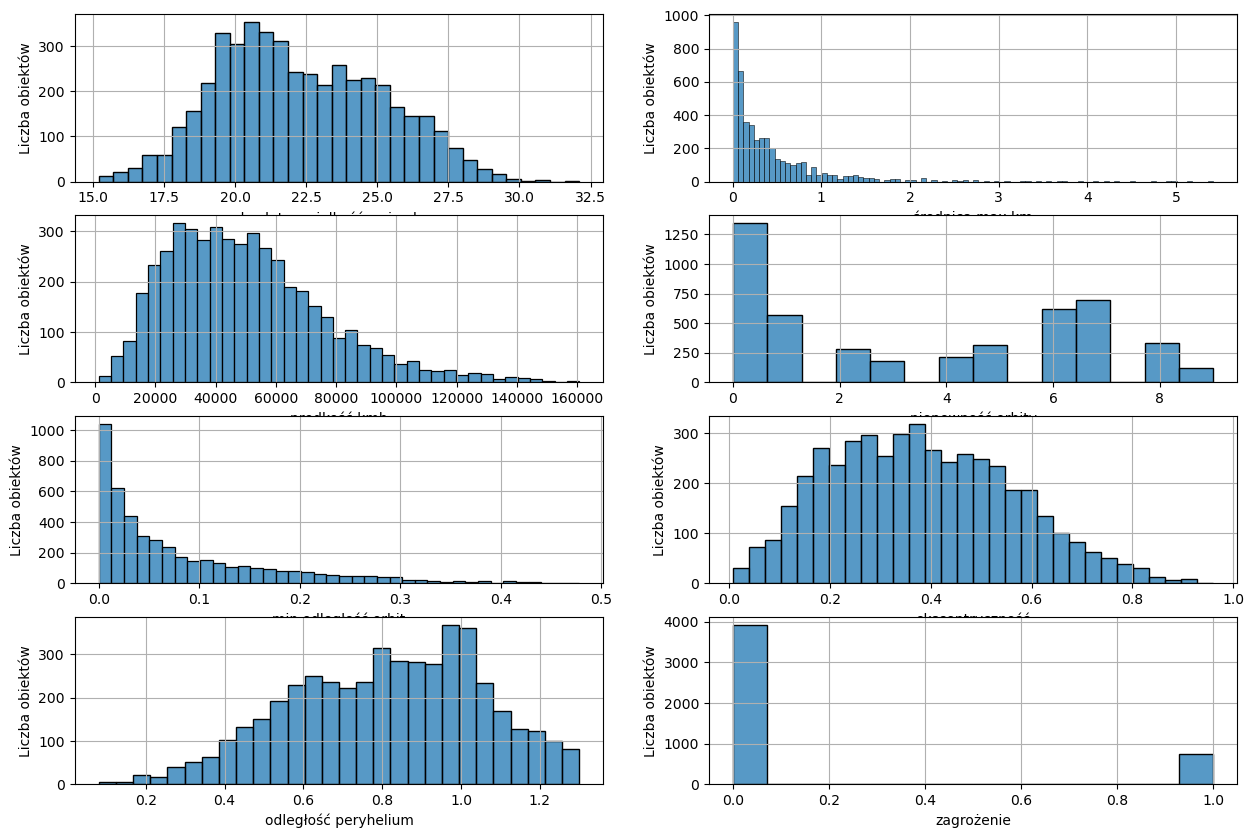

In [69]:
plt.figure(figsize = (15, 10))

for i in range(len(df.columns)):
    plt.subplot(4, 2, i+1)
    sns.histplot(df.iloc[:, i]).set(ylabel='Liczba obiektów')
    plt.grid()

Przyjrzyjmy się teraz wszystkim cechom przyjętym do analizy po kolei.

##### absolutna wielkość gwiazdowa

Zacznijmy od dystrybucji tej cechy:

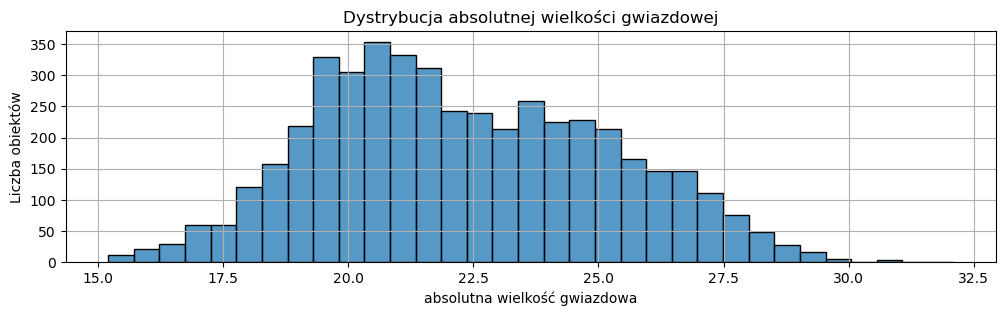

In [70]:
plt.figure(figsize=(12, 3))
sns.histplot(df["absolutna wielkość gwiazdowa"]).set(ylabel='Liczba obiektów')
plt.title("Dystrybucja absolutnej wielkości gwiazdowej")
plt.grid()

Jak widać, liczba obiektów o średniej absolutnej wielkości gwiazdowej jest największa. Przyjrzyjmy się teraz korelacji między cechami absolutna wielkość gwiazdowa i zagrożenie:

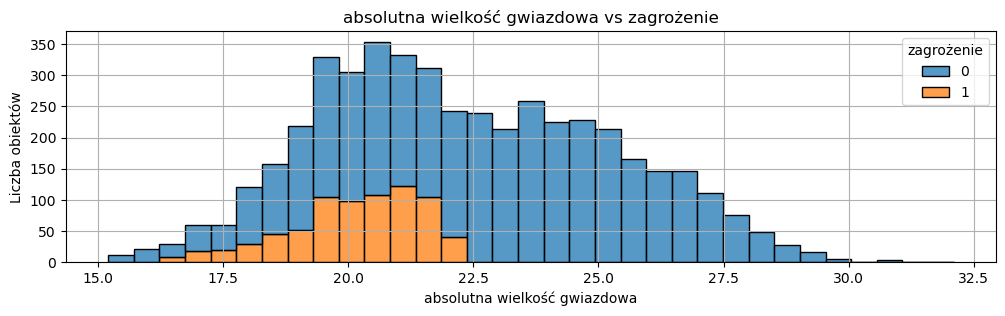

In [71]:
plt.figure(figsize=(12, 3))
sns.histplot(data=df, x=df["absolutna wielkość gwiazdowa"], hue="zagrożenie", multiple='stack').set(ylabel='Liczba obiektów')
plt.title("absolutna wielkość gwiazdowa vs zagrożenie")
plt.grid()

Wartość korelacji dla pary absolutna wielkość gwiazdowa - zagrożenie wynosi -0,327441 i jest to dość mocna korelacja ujemna. Wraz ze wzrostem absolutnej wielkości gwiazdowej od pewnego momentu następuje spadek zagrożenia, co widoczne jest na wykresie. 

##### średnica max km

Zacznijmy od dystrybucji tej cechy:

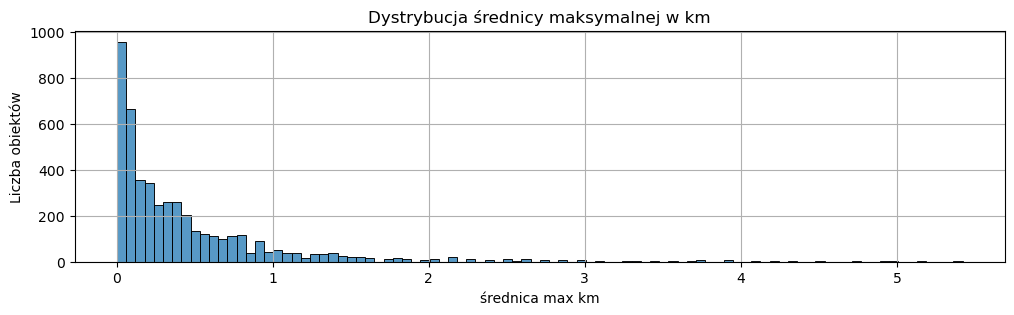

In [72]:
plt.figure(figsize=(12, 3))
sns.histplot(df["średnica max km"]).set(ylabel='Liczba obiektów')
plt.title("Dystrybucja średnicy maksymalnej w km")
plt.grid()

Jak widać, zdecydowanie najwięcej jest obiektów małych. Przyjrzyjmy się teraz korelacji między cechami średnica max km i zagrożenie:

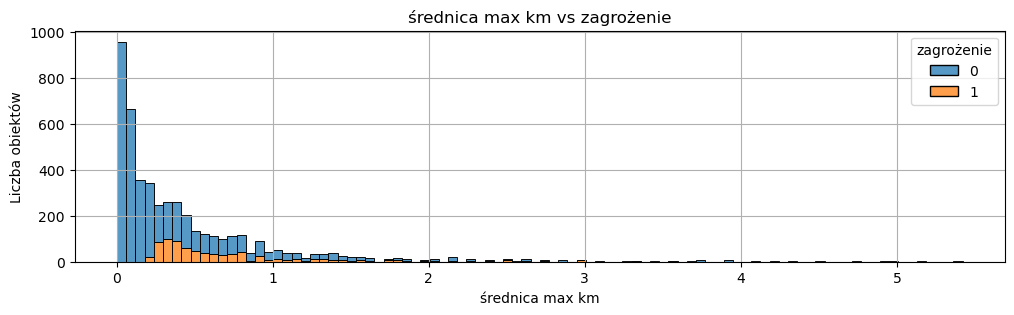

In [73]:
plt.figure(figsize=(12, 3))
sns.histplot(data=df, x=df["średnica max km"], hue="zagrożenie", multiple='stack').set(ylabel='Liczba obiektów')
plt.title("średnica max km vs zagrożenie")
plt.grid()

Wartość korelacji dla pary średnica max km - zagrożenie wynosi 0,185663 i jest to dość słaba korelacja dodatnia. Wraz ze wzrostem średnicy maksymalnej następuje wzrost zagrożenia.

##### prędkość kmh

Zacznijmy od dystrybucji tej cechy:

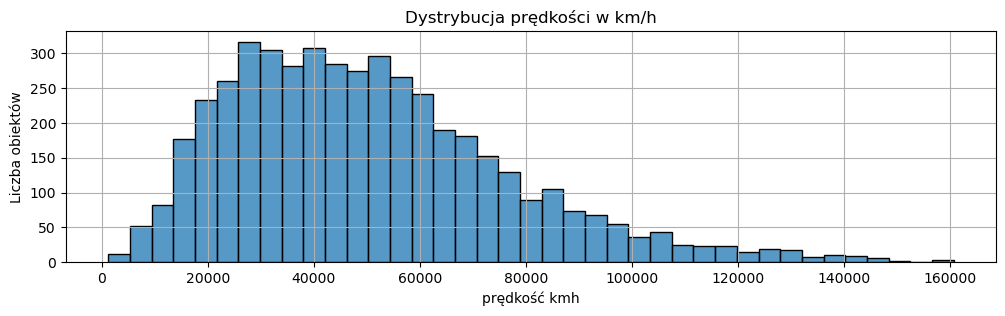

In [74]:
plt.figure(figsize=(12, 3))
sns.histplot(df["prędkość kmh"]).set(ylabel='Liczba obiektów')
plt.title("Dystrybucja prędkości w km/h")
plt.grid()

Jak widać, więcej jest obiektów poruszających się z mniejszymi prędkościami. Przyjrzyjmy się teraz korelacji między cechami prędkość kmh i zagrożenie:

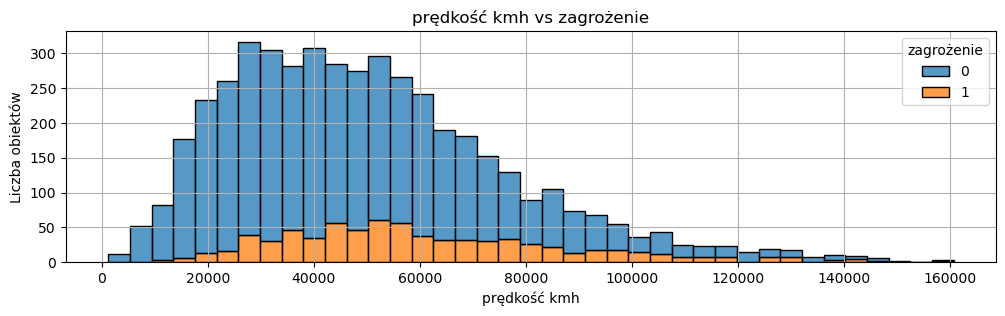

In [75]:
plt.figure(figsize=(12, 3))
sns.histplot(data=df, x=df["prędkość kmh"], hue="zagrożenie", multiple='stack').set(ylabel='Liczba obiektów')
plt.title("prędkość kmh vs zagrożenie")
plt.grid()

Wartość korelacji dla pary prędkość kmh - zagrożenie wynosi 0,191372 i jest to dość słaba korelacja dodatnia. Wraz ze wzrostem prędkości następuje wzrost zagrożenia.

##### niepewność orbity

Zacznijmy od dystrybucji tej cechy:

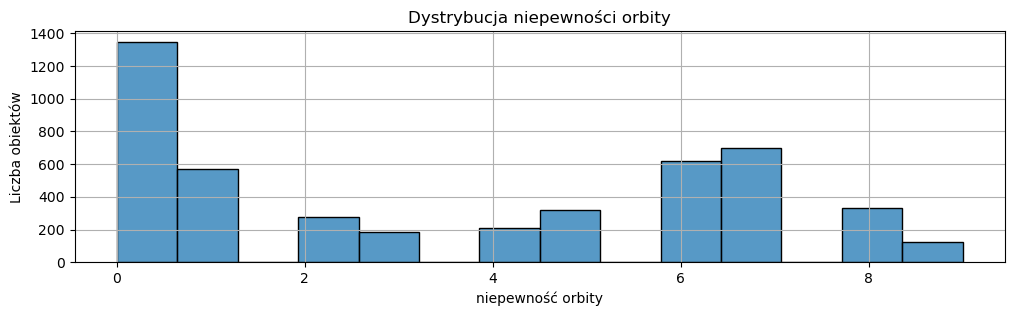

In [76]:
plt.figure(figsize=(12, 3))
sns.histplot(df["niepewność orbity"]).set(ylabel='Liczba obiektów')
plt.title("Dystrybucja niepewności orbity")
plt.grid()

Jak widać, najwięcej jest obiektów o małej niepewności orbity. Przyjrzyjmy się teraz korelacji między cechami niepewność orbity i zagrożenie:

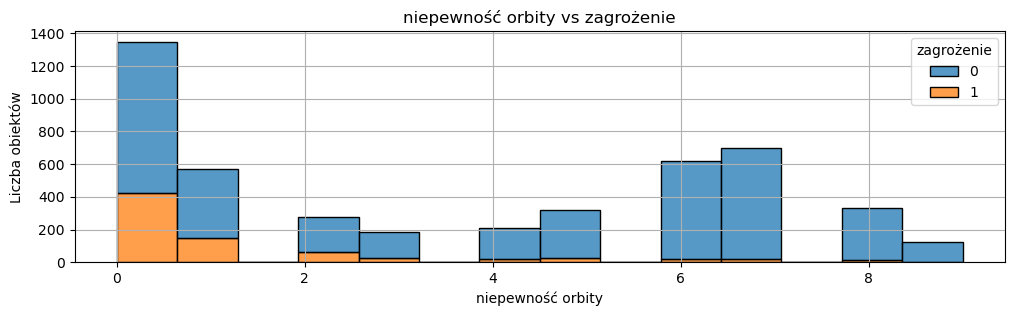

In [77]:
plt.figure(figsize=(12, 3))
sns.histplot(data=df, x=df["niepewność orbity"], hue="zagrożenie", multiple='stack').set(ylabel='Liczba obiektów')
plt.title("niepewność orbity vs zagrożenie")
plt.grid()

Wartość korelacji dla pary niepewność orbity - zagrożenie wynosi -0,328843 i jest to dość mocna korelacja ujemna. Wraz ze wzrostem niepewności orbity następuje spadek zagrożenia.

##### min odległość orbit

Zacznijmy od dystrybucji tej cechy:

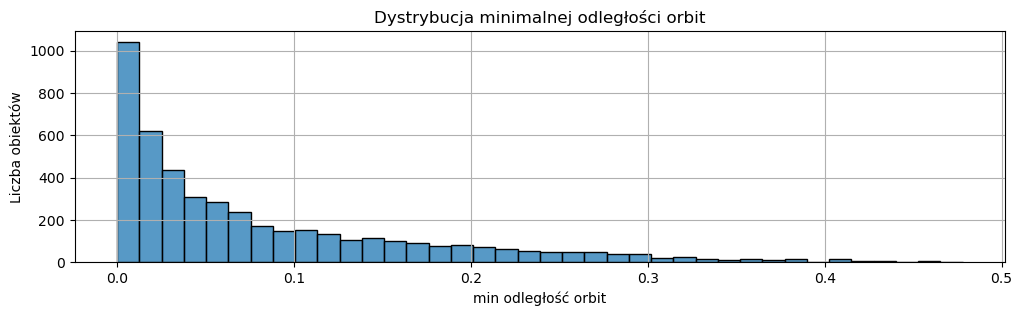

In [78]:
plt.figure(figsize=(12, 3))
sns.histplot(df["min odległość orbit"]).set(ylabel='Liczba obiektów')
plt.title("Dystrybucja minimalnej odległości orbit")
plt.grid()

Jak widać, zdecydowanie najwięcej jest obiektów o małej wartości tej cechy. Przyjrzyjmy się teraz korelacji między cechami min odległość orbit i zagrożenie:

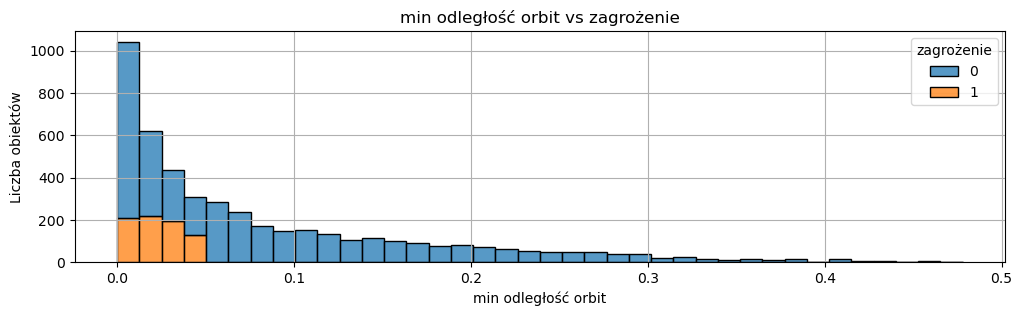

In [79]:
plt.figure(figsize=(12, 3))
sns.histplot(data=df, x=df["min odległość orbit"], hue="zagrożenie", multiple='stack').set(ylabel='Liczba obiektów')
plt.title("min odległość orbit vs zagrożenie")
plt.grid()

Wartość korelacji dla pary min odległość orbit - zagrożenie wynosi -0,288426 i jest to dość silna korelacja ujemna. Wraz ze wzrostem minimalnej odległości orbit następuje spadek zagrożenia.

##### ekscentryczność

Zacznijmy od dystrybucji tej cechy:

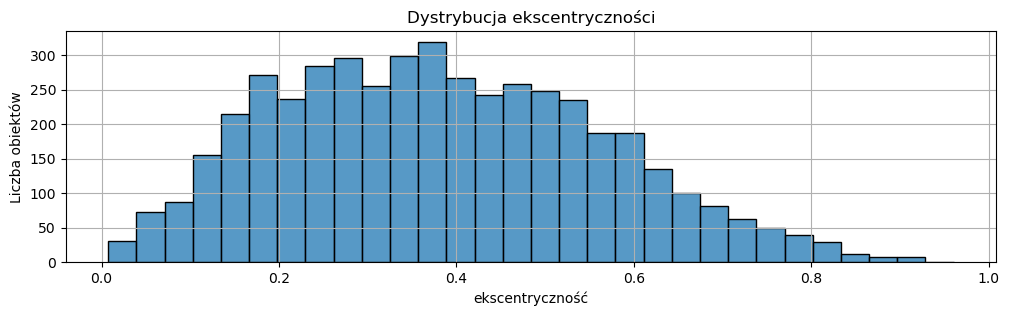

In [80]:
plt.figure(figsize=(12, 3))
sns.histplot(df["ekscentryczność"]).set(ylabel='Liczba obiektów')
plt.title("Dystrybucja ekscentryczności")
plt.grid()

Jak widać, liczba obiektów o średniej ekscentryczności jest największa. Przyjrzyjmy się teraz korelacji między cechami ekscentryczność i zagrożenie:

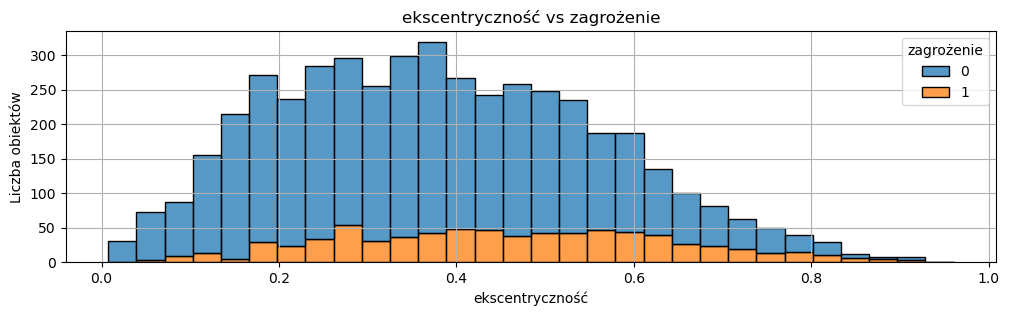

In [81]:
plt.figure(figsize=(12, 3))
sns.histplot(data=df, x=df["ekscentryczność"], hue="zagrożenie", multiple='stack').set(ylabel='Liczba obiektów')
plt.title("ekscentryczność vs zagrożenie")
plt.grid()

Wartość korelacji dla pary ekscentryczność - zagrożenie wynosi 0,183528 i jest to dość słaba korelacja dodatnia. Wraz ze wzrostem ekscentryczności następuje wzrost zagrożenia.

##### odległość peryhelium

Zacznijmy od dystrybucji tej cechy:

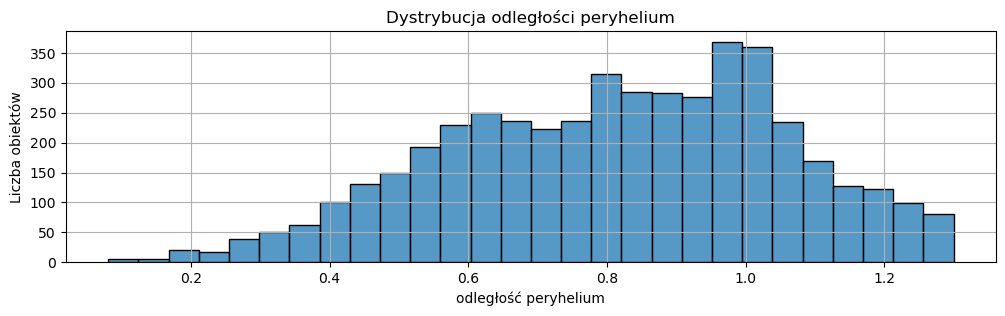

In [82]:
plt.figure(figsize=(12, 3))
sns.histplot(df["odległość peryhelium"]).set(ylabel='Liczba obiektów')
plt.title("Dystrybucja odległości peryhelium")
plt.grid()

Jak widać, najwięcej jest obiektów o średniej i nieco wyższej wartości tej cechy. Przyjrzyjmy się teraz korelacji między cechami odległość peryhelium i zagrożenie:

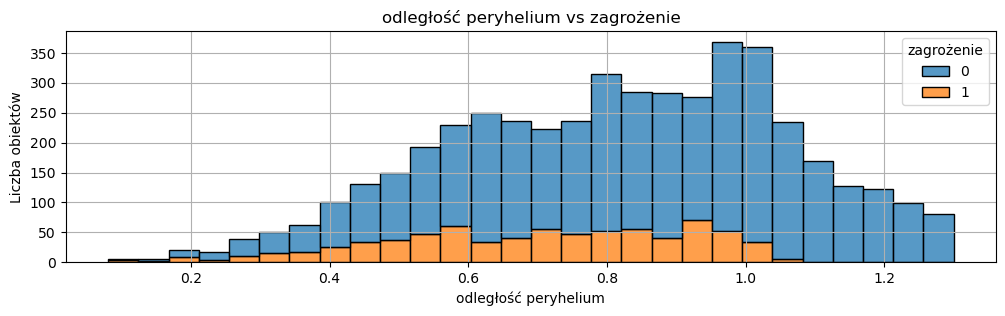

In [83]:
plt.figure(figsize=(12, 3))
sns.histplot(data=df, x=df["odległość peryhelium"], hue="zagrożenie", multiple='stack').set(ylabel='Liczba obiektów')
plt.title("odległość peryhelium vs zagrożenie")
plt.grid()

Wartość korelacji dla pary odległość peryhelium - zagrożenie wynosi -0,207016 i jest to średnia korelacja ujemna. Wraz ze wzrostem odległości peryhelium następuje spadek zagrożenia.

### Przygotowanie danych do trenowania modeli

Kolejne kroki związane są z inżynierią danych i przygotowaniem danych do trenowania modeli. Ważne jest, aby czynności te wykonać w odpowiedniej kolejności, dzięki czemu unikniemy wycieku danych i zachowamy integralność danych testowych, co jest istotne zwłaszcza w kontekście późniejszej ewaluacji modeli.

W szczególności, kolejność ta jest następująca:

1) Podział danych na zbiór treningowy i testowy
2) Czynności związane z inżynierią cech (np. kodowanie danych kategorycznych, skalowanie danych numerycznych)
3) Balansowanie danych (np. metodą SMOTE)

W przypadku drugiego etapu, w ramach inżynierii cech, najpierw kodujemy dane kategoryczne na numeryczne, a dopiero potem dokonujemy ich skalowania. W przypadku naszego zbioru nie ma danych kategorycznych, więc kodowanie odpada.

#### Podział danych na zbiór treningowy i zbiór testowy

Zanim przystąpimy do transformacji danych w ramach inżynierii cech, podzielimy dane na dwa oddzielne zbiory, zbiór treningowy i zbiór testowy. Wykorzystamy do tego metodę train_test_split z bibioteki sklearn:

In [84]:
from sklearn.model_selection import train_test_split

Najpierw musimy oddzielić kolumnę docelową od pozostałych:

In [85]:
X = df.drop(columns=['zagrożenie']) 
y = df['zagrożenie'] 

X to dane wejściowe, czyli wszystkie cechy oprócz tej, którą chcemy przewidzieć.<br>
y to wartość docelowa, którą chcemy przewidzieć.

Teraz podzielimy dane na zbiór treningowy i testowy:

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Parametr test_size używany jest do określenia proporcji, w jakich następuje podział na oba zbiory. W tym przypadku 20% danych będzie przypisane do zbioru testowego, pozostałe 80% do treningowego.

Parametr random_state zapewnia odtwarzalność podziału. Ogólnie podział polega na przypadkowym przypisaniu odpowiednich ilości danych do każdego zbioru, za każdym razem inaczej. Dzięki temu parametrowi podział staje się deterministyczny, czyli za każdym razem uzyskujemy identyczne zbiory. Do parametru tego często przypisuje się wartość 42, ale może to być każda dowolna wartość.

Funkcja train_test_split zwraca:
- X_train - zbiór treningowy cech, używanych do trenowania modeli
- X_test - zbiór testowy cech, używanych do ewaluacji modeli
- y_train - zbiór treningowy wartości docelowych
- y_test - zbiór testowy wartości docelowych

#### Inżynieria cech

Inżynieria cech to szeroki temat, który obejmuje w szczególności:

- tworzenie nowych cech:
  - w oparciu o znajomość danej domeny
  - w oparciu o obserwację wzorów występujących w danych
  - poprzez łączenie istniejących cech
- transformacje cech:
  - normalizacja (zmiana skali cech na podobny zakres, np. od 0 do 1, dzięki czemu żadna cecha nie dominuje nad pozostałymi)
  - skalowanie (zmiana cech w celu uzyskania podobnej skali, np. odchylenia standardowego równego 1, dzięki czemu mamy pewność, że wszystkie cechy uwzględnione są w równym stopniu)
    - skalowanie min-max (zmiana skali do określonego zakresu, np. 0-1, przez odjęcie wartości minimalnej i podzielenie przez zakres)
    - skalowanie standardowe (zmiana skali w celu uzyskania średniej równej 0 i odchylenia standardowego równego 1, dokonywana przez odjęcie średniej i podzielenie przez odchylenie standardowe)
    - skalowanie odporne (zmiana skali w celu zapewniena odporności na wartości odstające - outliers, dokonywana poprzez podzielenie ich przez zakres interkwartylowy)
  - kodowanie (zmiana cech kategorycznych na numeryczne, np. kodowanie one-hot i kodowanie etykiet)
  - transformacje matematyczne (w celu zmiany rozkładu lub skali cech, np. transformacja logarytmiczna, pierwiastkowa, odwrotna, itp.)
- ekstrakcja cech
  - redukcja wymiarowości (redukcja liczby cech przy zachowaniu ważnych informacji, np. PCA, t-SNE)
  - kombinacja cech (łącznie kilku cech w jedną)
  - agregacja cech (tworzenie nowych cech przez agragację cech istniejących, np. cechy będącej sumą albo średnią innych cech)
  - transformacja reprezentacji (nowa reprezentacja cechy lub jej części)
 
Oczywiście nie oznacza to, że w każdym przypadku wykonujemy wszystkie te operacje. To, które wykonujemy, zależy od samych danych oraz od tego, co chcemy osiągnąć.

W naszym zbiorze mamy tylko dane numeryczne. W ramach inżynierii cech wykonamy tylko jedną operację, skalowanie standardowe. Podobnie, jak w przypadku podziału na zbiór treningowy i testowy, skorzystamy z gotowych rozwiązań:

In [87]:
from sklearn.preprocessing import StandardScaler

Ważne jest, aby skalowanie było początkowo wykonane jedynie na zbiorze treningowym, tak aby dane ze zbioru testowego nie miały wpływu na proces skalowania. Pozwoli nam to zapobiec wyciekowi danych. Następnie, uzyskane w ten sposób parametry, tj. średnia i odchylenie standardowe, będą zastosowane do zbioru testowego.

Przyjrzyjmy się danym w zbiorze treningowym przed skalowaniem:

In [88]:
X_train.head()

,absolutna wielkość gwiazdowa,średnica max km,prędkość kmh,niepewność orbity,min odległość orbit,ekscentryczność,odległość peryhelium
3845,21.6,0.284472,49934.573934,0,0.013959,0.132046,0.983580
2091,27.1,0.022596,26977.385172,7,0.002469,0.054303,0.984672
3114,24.8,0.065169,44965.211003,7,0.020646,0.255377,0.770181
2871,18.4,1.241767,77543.269277,0,0.282797,0.845545,0.282878
4253,20.8,0.411188,44689.341698,0,0.000136,0.200847,0.860054


Przeskalujmy dane:

In [89]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

X_test_scaled = scaler.transform(X_test)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

Przyjrzyjmy się naszym danym po przeskalowaniu:

In [90]:
X_train.head()

,absolutna wielkość gwiazdowa,średnica max km,prędkość kmh,niepewność orbity,min odległość orbit,ekscentryczność,odległość peryhelium
3845,-0.242022,-0.257821,0.001102,-1.149829,-0.756219,-1.390467,0.696725
2091,1.672827,-0.697347,-0.881166,1.132914,-0.883155,-1.826253,0.701252
3114,0.872072,-0.625895,-0.189876,1.132914,-0.682350,-0.699144,-0.188597
2871,-1.356116,1.348879,1.062132,-1.149829,2.213757,2.608999,-2.210248
4253,-0.520546,-0.045145,-0.200478,-1.149829,-0.908930,-1.004808,0.184258


Dane zostały przeskalowane w taki sposób, że ich średnia wynosi 0, a odchylenie standardowe 1.

#### Niezbalansowane dane - metoda SMOTE

Problem niezbalansowanych danych dotyczy głównie cechy docelowej, ale może dotyczyć także cech silnie skorelowanych z cechą docelową. Polega on na tym, rozkład cechy docelowej jest mocno asymetryczny i jedna klasa dominuje znacznie nad pozostałymi.

Może to negatywnie wpływać na proces trenowania modelu, gdyż wartość mniejszościowa nie będzie miała odpowiedniego wkładu w uczenie modelu. Niezbalansowane dane mogą być przyczyną błędnych metryk dla modelu, gdyż nawet jeśli model będzie za każdym razem przewidywać klasę dominującą, i tak będzie uzyskiwać dużą dokładność.

Problem niezbalansowanych danych możemy rozwiązać na przykład za pomocą metody SMOTE (Synthetic Minority Oversampling Technique), która polega na generowaniu próbek syntetycznych z klasy mniejszościowej. Aby uniknąć wycieku danych, stosujemy ją tylko dla zbioru treningowego.

Metoda SMOTE ma zastosowanie przede wszystkim w klasyfikacji binarnej, ale można ją także zaadaptować do klasyfikacji niebinarnej.

Metodę SMOTE stosujemy do przeskalowanych danych, aby generowane dane mieściły się w tej samej przestrzeni cech. Na początek sprawdźmy, czy cecha docelowa jest zbalansowana:

In [91]:
y_train.value_counts()

zagrożenie
0    3137
1     603
Name: count, dtype: int64

Jak widać, liczba danych w klasie mniejszościowej stanowi niecałe 20% liczby w klasie większościowej. Możemy tu zatem mówić o niezbalansowanych danych, ale jest to niezbalansowanie umiarkowane, dlatego możemy zrezygnować z zastosowania metody SMOTE, która sama z siebie także niesie pewne ryzyka, np. ryzyko nadmiernego dopasowania (overfitting). Możemy przystąpić do trenowania modeli.

## 3. Trenowanie modeli

Wytrenujemy kilka modeli, a następnie porównamy je za pomocą łatwych do zrozumienia metryk. Będą to zarówno modele tradycyjnego uczenia maszynowego (machine learning), jak i uczenia głębokiego (deep learning). Zacznijmy od zaimportowania niezbędnych modeli i metryk:

Wytrenujemy kilka modeli, a następnie porównamy je za pomocą łatwych do zrozumienia metryk. Będą to zarówno modele tradycyjnego uczenia maszynowego (machine learning), jak i model uczenia głębokiego (deep learning) wykorzystujący wielowarstwowy perceptron (multilayer perceptron, MLP). 

Zaczniemy od tradycyjnych modeli uczenia maszynowego, a następnie przejdziemy do MLP.

### Tradycyjne modele uczenia maszynowego

Zacznijmy od zaimportowania niezbędnych modeli tradycyjnego uczenia maszynowego i metryk:

In [92]:
# tradycyjne modele uczenia maszynowego
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, 
    GradientBoostingClassifier,
    ExtraTreesClassifier
)
from xgboost import XGBClassifier

# metryki
from sklearn.metrics import (
    accuracy_score,
    precision_score, 
    recall_score,      
    f1_score, 
    classification_report, 
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    precision_recall_curve,
    PrecisionRecallDisplay,
    roc_auc_score, 
    RocCurveDisplay
)

Proces trenowania i ewaluacji modeli jest powtarzalny i obejmuje następujące kroki dla każdego modelu:
1) tworzenie modelu z zestawem hiperparametrów (zaczniemy z domyślnymi wartościami hiperparametrów)
2) trenowanie modelu
3) użycie modelu w celu predykcji cechy docelowej w zbiorze testowym
4) ewaluacja modelu

Dla uproszczenia, umieścimy wszystkie modele z słowniku. Utworzymy je na razie z domyślnymi wartościami hiperparametrów. Wyjątkiem od tej reguły, tam gdzie to możliwe, będzie hiperparametr random_state, którego użyjemy w celu zapewnienia powtarzalności wyników. 

Niektóre hiperparametry mogą później wymagać dostrojenia, ale nie będziemy tego wiedzieli przed przetrenowaniem modeli. Każdy model posiada bardzo dużo hiperparametrów, niektóre z nich mogą przyjmować wartości w dużych zakresach, ale na ten moment nie będziemy się nimi przejmować.

Oto nasze modele:

In [93]:
models = {
    'Naiwny klasyfikator Bayesa': GaussianNB(),
    'Regresja logistyczna': LogisticRegression(),
    'Metoda k-najbliższych sąsiadów': KNeighborsClassifier(),
    'Drzewo decyzyjne': DecisionTreeClassifier(random_state=42),
    'Las losowy': RandomForestClassifier(random_state=42),
    'Wzmocnienie gradientowe': GradientBoostingClassifier(random_state=42),
    'Extra Trees': ExtraTreesClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42)
}

Aby uprościć sobie zadanie, zdefiniujmy kilka funckji. Zacznijmy od funkcji ewaluującej model:

In [94]:
def evaluate_model(y_test, y_pred, y_prob):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    metrics = {
        'Dokładność': accuracy,
        'Precycja': precision,
        'Czułość': recall,    
        'Wynik F1': f1,
        'ROC AUC': roc_auc
    }
    
    s_metrics = pd.Series(metrics)

    print('METRYKI KLASYFIKACJI\n')
    for key, value in metrics.items():
        print(f'{key}: {value:.4f}')

    print()

    # Raport z klasyfikacji
    print('RAPORT Z KLASYFIKACJI\n')
    print(classification_report(y_test, y_pred))
    print()

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    # Podstawowe metryki
    s_metrics.plot(ax=axes[0, 0], kind='bar', grid=True)
    axes[0, 0].set_title('PODSTAWOWE METRYKI')
            
    # Krzywa precyzji i czułości
    prec, rec, thresholds = precision_recall_curve(y_test, y_prob)
    PrecisionRecallDisplay(precision=prec, recall=rec).plot(ax=axes[0, 1])    
    axes[0, 1].set_title('KRZYWA PRECYZJI I CZUŁOŚCI')
    axes[0, 1].set_xlabel('Czułość')  
    axes[0, 1].set_ylabel('Precyzja')  
    
    # Tablica pomyłek   
    cm = confusion_matrix(y_test, y_pred)      
    ConfusionMatrixDisplay(
        confusion_matrix = cm, 
        display_labels = ['Nie zagraża', 'Zagraża']).plot(ax=axes[1, 0])
    axes[1, 0].set_title('TABLICA POMYŁEK')
    axes[1, 0].set_xlabel('Klasa predykowana')  
    axes[1, 0].set_ylabel('Klasa rzeczywista') 

    # Krzywa ROC 
    RocCurveDisplay.from_predictions(y_test, y_prob, ax=axes[1, 1])
    axes[1, 1].set_title('KRZYWA ROC')
    axes[1, 1].set_xlabel('Frakcja wyników fałszywie pozytywnych')  
    axes[1, 1].set_ylabel('Frakcja wyników prawdziwie pozytywnych')  
    
    plt.tight_layout()
    plt.show()
    
    return metrics

Aby zrozumieć jak działa powyższa funkcja, przypomnijmy sobie wszystkie metryki, jakie są w niej wykorzystane:

**<u>Dokładność (Accuracy)</u>** - stosunek prawidłowych klasyfikacji do wszystkich klasyfikacji<br>

$ \text{Dokładność} = \frac{\text{Prawdziwie Pozytywne (True Positives)}\, + \,\text{Prawdziwie Negatywne (True Negatives)}}{\text{Wszystkie klasyfikacje}} $<br>

Dokładność odpowiada na pytanie: Jak często model ma rację?<br>
Największe znaczenie ma dla zbiorów zbalansowanych.<br>


**<u>Precyzja (Precision)</u>** - stosunek klasyfikacji prawdziwie pozytywnych (true positive) do wszystkich klasyfikacji pozytywnych<br>

$ \text{Precyzja} = \frac{\text{Prawdziwie Pozytywne (True Positives)}}{\text{Prawdziwie Pozytywne (True Positives)}\, + \,\text{Fałszywie Pozytywne (False Positives)}} $<br>

Precyzja odpowiada na pytanie: Jak często klasyfikacje pozytywne są prawidłowe?<br>
Ma ona największe znaczenie gdy zależy nam szczególnie na minimalizacji klasyfikacji fałszywie pozytywnych.<br>


**<u>Czułość (Recall)</u>** - stosunek klasyfikacji prawdziwie pozytywnych (true positive) do wszystkich klasyfikacji pozytywnych<br>

$ \text{Czułość} = \frac{\text{Prawdziwie Pozytywne (True Positives)}}{\text{Prawdziwie Pozytywne (True Positives)}\, + \,\text{Fałszywie Negatywne (False Negatives)}} $<br>

Czułość nazywany jest również współczynnikiem prawdziwie pozytywnych.Odpowiada ona na pytanie: Ile spośród wszystkich rzeczywistych pozytywnych zostało sklasyfikowane prawidłowo?<br>
Ma ona największe znaczenie gdy zależy nam szczególnie na minimalizacji klasyfikacji fałszywie negatywnych.<br>


**<u>Wynik F1 (F1 Score)</u>** - średnia harmoniczna precyzji i czułości<br>

$ \text{F1} = 2\, \times \,\frac{\text{Precyzja (Precision)}\, \times \,\text{Czułość (Recall)}}{\text{Precyzja (Precision)}\, + \,\text{Czułość (Recall)}} $<br>

Metryka ta jest najbardziej przydatna w przypadku zbiorów niezbalansowanych, gdzie potrzebna jest nam jedna metryka aby zbalansować precyzję i czułość.<br>


**<u>Krzywa AUC-ROC (AUC-ROC Curve)</u>** (Obszar pod krzywą charakterystyki operacyjnej odbiornika) - graficzna reprezentacja wydajności modelu klasyfikacji binarnej na różnych wartościach progowych<br>

Mamy tu dwa pojęcia:
- Krzywa ROC (ROC Curve) - Krzywa charakterystyki operacyjnej odbiornika (Receiver Operating Characteristic Curve) - wykres zależności między czułością (odsetek prawdziwie pozytywnych) a odsetkiem fałszywie pozytywnych na różnych wartościach progowych
- AUC - Obszar pod krzywą (Area Under the Curve) - pojedyncza wartość między 0 a 1 opisująca krzywą (1 oznacza doskonałą klasyfikację, 0.5 oznacza klasyfikację losową)

Krzywa AUC-ROC używana jest do oceny ogólnej wydajności modelu i ma największe zastosowanie w przypadku zbiorów niezbalansowanych.<br>

Czym bliżej krzywa jest lewego górnego rogu (0.0, 1.0), tym lepsza jest zdolność klasyfikacyjna modelu.<br>


**<u>Krzywa precyzji i czułości (Precision-Recall Curve)</u>** - wykres zależności pomiędzy precyzją a czułością<br>
Jest szczególnie przydatna, gdy precyzja i czułość są istotne, zwłaszcza dla zbiorów niezbalansowanych. Im bliżej krzywa jest prawego górnego rogu, tym lepiej model sobie radzi.


**<u>Tablica pomyłek (Confusion Matrix)</u>** - zestawienie wyników klasyfikacji: prawdziwie pozytywne (true positives), prawdziwie negatywne (true negatives), przewidywane pozytywne (predicted positives) i przewidywane negatywne (predicted negatives)<br>
Informuje nas gdzie model popełnia błędy klasyfikacyjne.

Ważne jest także, aby wiedzieć, które metryki mają większe, a które mniejsze znaczenie dla danego modelu. Tak więc, w zależności od rodzaju zbioru danych, na którym pracujemy, powinniśmy się skupić na następujących metrykach:

- Dokładność (Accuracy) - jeśli zbiór jest zbalansowany, a wszystkie błędy tak samo kosztowne,
- Precyzja (Precision) - jeśli fałszywe pozytywne klasyfikacje są bardziej kosztowne,
- Czułość (Recall) - jeśli fałszywe negatywne klasyfikacje są bardziej kosztowne,
- Wynik F1 (F1 Score) - jeśli zarówno precyzja, jak i czułość są ważne,
- ROC AUC - jeśli ważne jest ustalanie rankingu prawdopodobieństw lub ogólne zdolności dyskryminacyjne,
- Krzywa precyzji i czułości (Precision-Recall Curve) - jeśli zbiór jest niezbalansowany,
- Tablica pomyłek (Confusion Matrix) - zawsze, aby lepiej zrozumieć typy błędów i ich wpływ.

Jeśli chodzi o nasz zbiór danych, fałszywe negatywne klasyfikacje są zdecydowanie bardziej kosztowne niż fałszywe pozytywne klasyfikacje, bo zaklasyfikowanie obiektu zagrażającego jako niezagrażającego może być dla nas znacznie bardziej niebezpieczne niż zaklasyfikowanie obiektu niezagrażającego jako zagrażającego. W związku z tym, powinniśmy zwracać uwagę na czułość. Ważną metryką jest także ROC AUC, która mówi nam jak dobrze model sobie radzi z rozróżnianiem klas. Aby lepiej zrozumieć błędy klasyfikacji, będziemy się przyglądać tablicy pomyłek. 

Pozostale metryki mają mniejsze znaczenie dla naszego zbioru.

Kolejna funkcja, którą zdefiniujemy, będzie służyła do trenowania i ewaluacji modelu:

In [95]:
def train_evaluate_model(model, model_name):
    print(model_name.upper() + '\n')
        
    # trenuj model
    model.fit(X_train, y_train)

    # dokonaj predykcji
    y_pred = model.predict(X_test)

    # predykuj prawdopodobieństwa dla klasy pozytywnej
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # ewaluuj model
    return evaluate_model(y_test, y_pred, y_prob)

Teraz wytrenujemy zewaluujemy wszystkie modele po kolei:

#### Naiwny klasyfikator Bayesa (Gaussian Naive Bayes)

Naiwny klasyfikator Bayesa jest klasyfikatorem probabilistycznym opartym na twierdzeniu Bayesa. Zakłada on, że cechy rozłożone są zgodnie z rozkładem Gaussa.

NAIWNY KLASYFIKATOR BAYESA

METRYKI KLASYFIKACJI

Dokładność: 0.9358
Precycja: 0.7647
Czułość: 0.8667
Wynik F1: 0.8125
ROC AUC: 0.9783

RAPORT Z KLASYFIKACJI

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       785
           1       0.76      0.87      0.81       150

    accuracy                           0.94       935
   macro avg       0.87      0.91      0.89       935
weighted avg       0.94      0.94      0.94       935




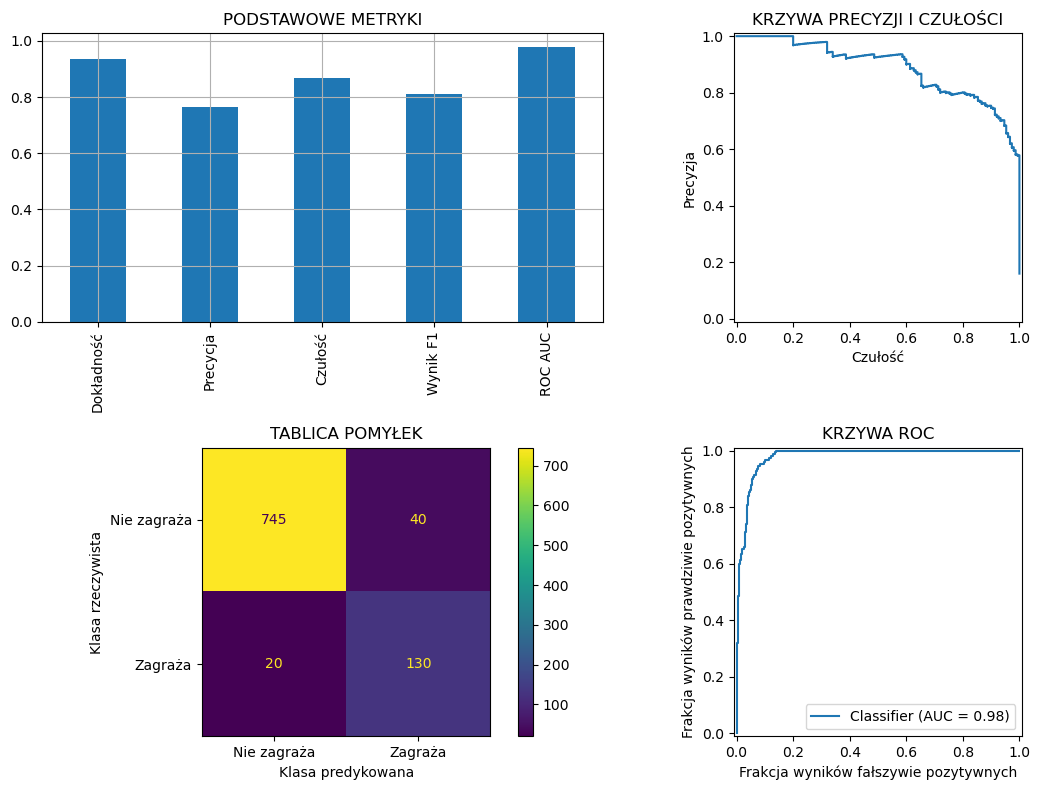

In [96]:
gnb = train_evaluate_model(models['Naiwny klasyfikator Bayesa'], 'Naiwny klasyfikator Bayesa')

**Interpretacja:**

Dokładność jest wysoka, ponad 93% próbek zostało sklasyfikowanych prawidłowo. Ta metryka nie jest zbyt wiarygodna dla niezbalansowanych zbiorów, takich jak ten (785 próbek klasy 0 kontra 150 próbek klasy 1).

Precyzja jest wysoka, tylko ponad 76% wszystkich próbek sklasyfikowanych jako pozytywne było sklasyfikowanych prawidłowo, co wskazuje na niewielką liczbę fałszywie pozytywnych.

Czułość jest wysoka, ponad 86% wszystkich rzeczywistych pozytywnych zostało sklasyfowane prawidłowo, więc model klasyfikuje pozytywne dość dobrze.

Wynik F1 jest wysoki, więc model charakteryzuje się dobrym balansem pomiędzy prawidłową klasyfikacją pozytywnych a unikaniem fałszywie pozytywnych.

ROC AUC jest bardzo wysokie, więc model dobrze radzi sobie z rozróżnianiem klas.

Z raportu klasyfikacji możemy wywnioskować co następuje:

- dla klasy 0 (negatywne, klasa większościowa):<br>
Precyzja: prawie wszystkie klasyfikacje negatywne są prawidłowe,<br>
Czułość: większość rzeczywistych negatywnych jest sklasyfikowanych prawidłowo,<br>
Wynik F1: model radzi sobie bardzo dobrze z negatywnymi<br>

- dla klasy 1 (pozytywne, klasa mniejszościowa):<br>
Precyzja: większość klasyfikacji pozytywnych jest prawidłowych,<br>
Czułość: większość rzeczywistych pozytywnych jest sklasyfikowanych prawidłowo,<br>
Wynik F1: model radzi sobie dobrze z pozytywnymi<br>

Krzywa precyzji i czułości zbliża się do prawego górnego rogu, więc model dobrze sobie radzi z balansowaniem precyzji i czułości. 

W tablicy pomyłek widzimy, że:
- liczba klasyfikacji prawdziwie pozytywnych: 130 - tyle razy rzeczywisty obiekt zagrażający został prawidłowo sklasyfikowany jako obiekt zagrażający,
- liczba klasyfikacji fałszywie pozytywnych: 40 - tyle razy rzeczywisty obiekt niezagrażający został nieprawidłowo sklasyfikowana jako obiekt zagrażający,
- liczba klasyfikacji prawdziwie negatywnych: 745 - tyle razy rzeczywisty obiekt niezagrażający został prawidłowo sklasyfikowany jako obiekt niezagrażający,
- liczba klasyfikacji fałszywie negatywnych: 20 - tyle razy rzeczywisty obiekt zagrażający został nieprawidłowo sklasyfikowany jako obiekt niezagrażający 

W tym przypadku najważniejsza jest minimalizacja liczby klasyfikacji fałszywie negatywnych. Na szczęście w tym modelu liczba obiektów zagrażających sklasyfikowanych jako obiekty niezagrażające jest niewielka.

Krzywa ROC znajduje się blisko lewego górnego rogu, więc można powiedzieć, że model radzi sobie z klasyfikacją bardzo dobrze.

#### Regresja logistyczna

Regresja logistyczna to model liniowy, który oblicza prawdopodobieństwo wyniku binarnego przy użyciu funkcji logistycznej.

REGRESJA LOGISTYCZNA

METRYKI KLASYFIKACJI

Dokładność: 0.9476
Precycja: 0.8061
Czułość: 0.8867
Wynik F1: 0.8444
ROC AUC: 0.9867

RAPORT Z KLASYFIKACJI

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       785
           1       0.81      0.89      0.84       150

    accuracy                           0.95       935
   macro avg       0.89      0.92      0.91       935
weighted avg       0.95      0.95      0.95       935




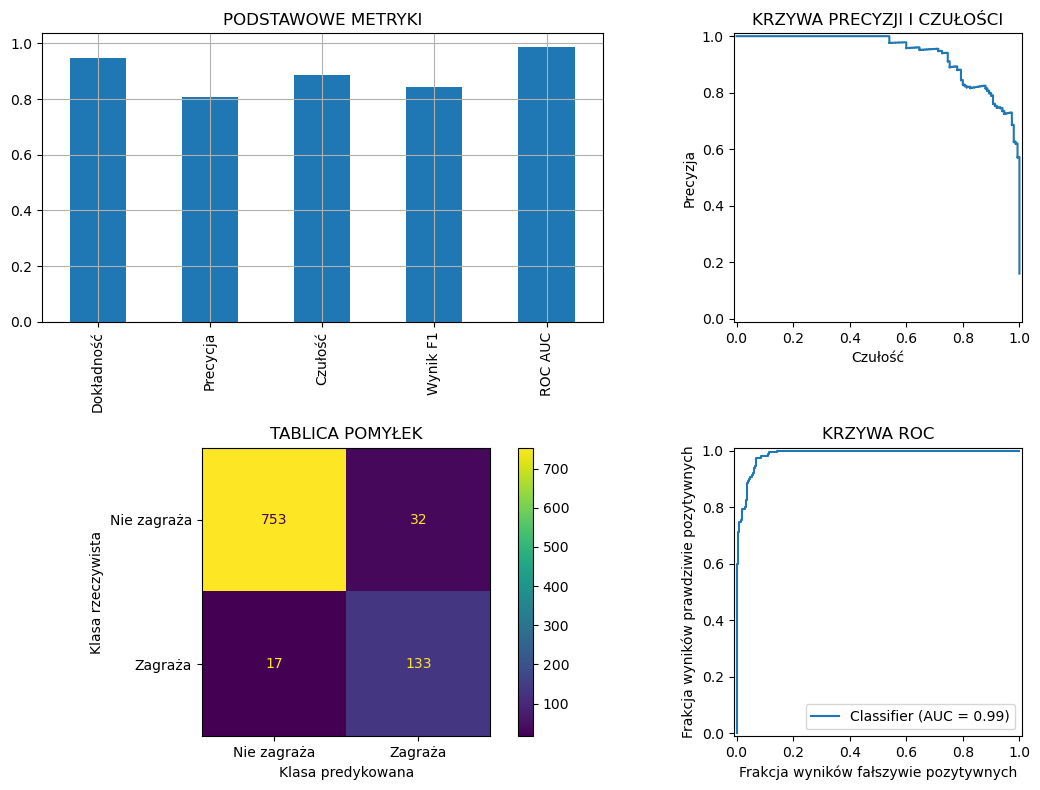

In [97]:
lr = train_evaluate_model(models['Regresja logistyczna'], 'Regresja logistyczna')

**Interpretacja:**

Dokładność jest wysoka, ponad 94% próbek zostało sklasyfikowanych prawidłowo. Ta metryka nie jest zbyt wiarygodna dla niezbalansowanych zbiorów, takich jak ten (785 próbek klasy 0 kontra 150 próbek klasy 1).

Precyzja jest wysoka, tylko ponad 80% wszystkich próbek sklasyfikowanych jako pozytywne było sklasyfikowanych prawidłowo, co wskazuje na niewielką liczbę fałszywie pozytywnych.

Czułość jest wysoka, ponad 88% wszystkich rzeczywistych pozytywnych zostało sklasyfowane prawidłowo, więc model klasyfikuje pozytywne dość dobrze.

Wynik F1 jest wysoki, więc model charakteryzuje się dobrym balansem pomiędzy prawidłową klasyfikacją pozytywnych a unikaniem fałszywie pozytywnych.

ROC AUC jest bardzo wysokie, więc model dobrze radzi sobie z rozróżnianiem klas.

Z raportu klasyfikacji możemy wywnioskować co następuje:

- dla klasy 0 (negatywne, klasa większościowa):<br>
Precyzja: prawie wszystkie klasyfikacje negatywne są prawidłowe,<br>
Czułość: większość rzeczywistych negatywnych jest sklasyfikowanych prawidłowo,<br>
Wynik F1: model radzi sobie bardzo dobrze z negatywnymi<br>

- dla klasy 1 (pozytywne, klasa mniejszościowa):<br>
Precyzja: większość klasyfikacji pozytywnych jest prawidłowych,<br>
Czułość: większość rzeczywistych pozytywnych jest sklasyfikowanych prawidłowo,<br>
Wynik F1: model radzi sobie dobrze z pozytywnymi<br>

Krzywa precyzji i czułości zbliża się do prawego górnego rogu, więc model dobrze sobie radzi z balansowaniem precyzji i czułości. 

W tablicy pomyłek widzimy, że:
- liczba klasyfikacji prawdziwie pozytywnych: 133 - tyle razy rzeczywisty obiekt zagrażający został prawidłowo sklasyfikowany jako obiekt zagrażający,
- liczba klasyfikacji fałszywie pozytywnych: 32 - tyle razy rzeczywisty obiekt niezagrażający został nieprawidłowo sklasyfikowana jako obiekt zagrażający,
- liczba klasyfikacji prawdziwie negatywnych: 753 - tyle razy rzeczywisty obiekt niezagrażający został prawidłowo sklasyfikowany jako obiekt niezagrażający,
- liczba klasyfikacji fałszywie negatywnych: 17 - tyle razy rzeczywisty obiekt zagrażający został nieprawidłowo sklasyfikowany jako obiekt niezagrażający 

W tym przypadku najważniejsza jest minimalizacja liczby klasyfikacji fałszywie negatywnych. Na szczęście w tym modelu liczba obiektów zagrażających sklasyfikowanych jako obiekty niezagrażające jest niewielka.

Krzywa ROC znajduje się blisko lewego górnego rogu, więc można powiedzieć, że model radzi sobie z klasyfikacją bardzo dobrze.

#### Metoda k-najbliższych sąsiadów

Metoda k-najbliższych sąsiadów to model, który klasyfikuje dane na podstawie klasy większościowej swoich najbliższych sąsiadów w przestrzeni cech. 

METODA K-NAJBLIŻSZYCH SĄSIADÓW

METRYKI KLASYFIKACJI

Dokładność: 0.9358
Precycja: 0.7812
Czułość: 0.8333
Wynik F1: 0.8065
ROC AUC: 0.9742

RAPORT Z KLASYFIKACJI

              precision    recall  f1-score   support

           0       0.97      0.96      0.96       785
           1       0.78      0.83      0.81       150

    accuracy                           0.94       935
   macro avg       0.87      0.89      0.88       935
weighted avg       0.94      0.94      0.94       935




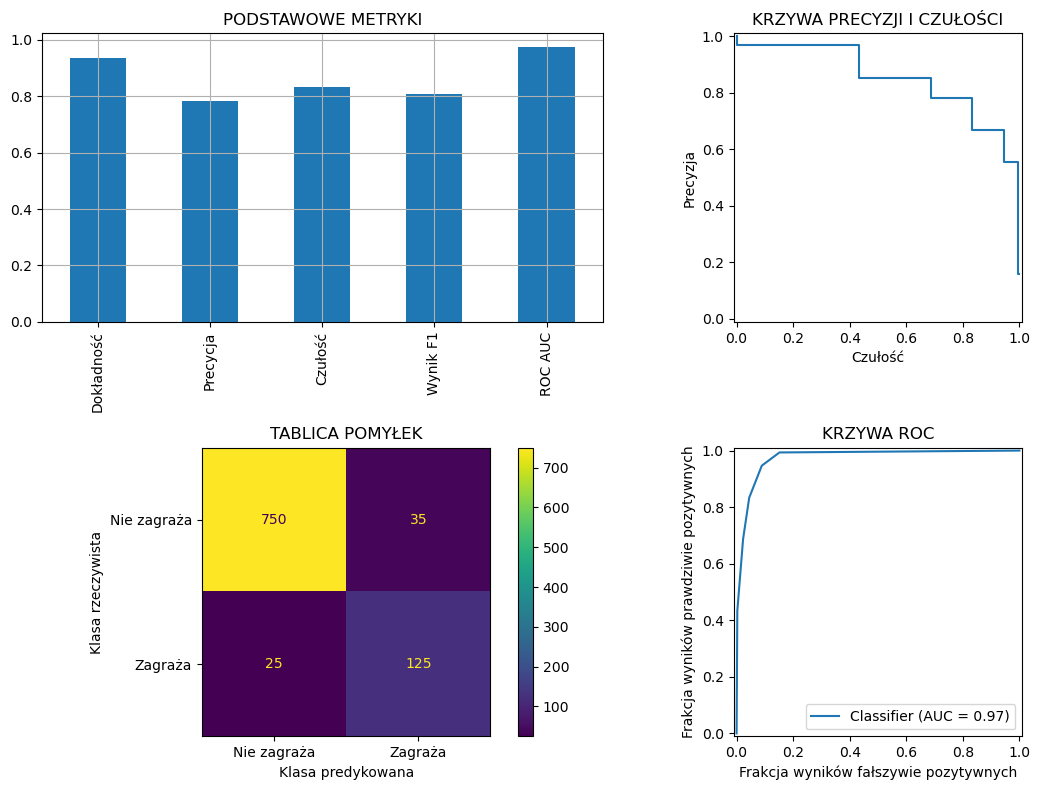

In [98]:
knn = train_evaluate_model(models['Metoda k-najbliższych sąsiadów'], 'Metoda k-najbliższych sąsiadów')

**Interpretacja:**

Dokładność jest wysoka, ponad 93% próbek zostało sklasyfikowanych prawidłowo. Ta metryka nie jest zbyt wiarygodna dla niezbalansowanych zbiorów, takich jak ten (785 próbek klasy 0 kontra 150 próbek klasy 1).

Precyzja jest wysoka, tylko ponad 78% wszystkich próbek sklasyfikowanych jako pozytywne było sklasyfikowanych prawidłowo, co wskazuje na niewielką liczbę fałszywie pozytywnych.

Czułość jest wysoka, ponad 83% wszystkich rzeczywistych pozytywnych zostało sklasyfowane prawidłowo, więc model klasyfikuje pozytywne dość dobrze.

Wynik F1 jest wysoki, więc model charakteryzuje się dobrym balansem pomiędzy prawidłową klasyfikacją pozytywnych a unikaniem fałszywie pozytywnych.

ROC AUC jest bardzo wysokie, więc model dobrze radzi sobie z rozróżnianiem klas.

Z raportu klasyfikacji możemy wywnioskować co następuje:

- dla klasy 0 (negatywne, klasa większościowa):<br>
Precyzja: prawie wszystkie klasyfikacje negatywne są prawidłowe,<br>
Czułość: prawie wszystkie negatywne są sklasyfikowane prawidłowo,<br>
Wynik F1: model radzi sobie bardzo dobrze z negatywnymi<br>

- dla klasy 1 (pozytywne, klasa mniejszościowa):<br>
Precyzja: większość klasyfikacji pozytywnych jest prawidłowych,<br>
Czułość: większość rzeczywistych pozytywnych jest sklasyfikowanych prawidłowo,<br>
Wynik F1: model radzi sobie dobrze z pozytywnymi<br>

Krzywa precyzji i czułości zbliża się do prawego górnego rogu, więc model dobrze sobie radzi z balansowaniem precyzji i czułości. 

W tablicy pomyłek widzimy, że:
- liczba klasyfikacji prawdziwie pozytywnych: 125 - tyle razy rzeczywisty obiekt zagrażający został prawidłowo sklasyfikowany jako obiekt zagrażający,
- liczba klasyfikacji fałszywie pozytywnych: 35 - tyle razy rzeczywisty obiekt niezagrażający został nieprawidłowo sklasyfikowana jako obiekt zagrażający,
- liczba klasyfikacji prawdziwie negatywnych: 750 - tyle razy rzeczywisty obiekt niezagrażający został prawidłowo sklasyfikowany jako obiekt niezagrażający,
- liczba klasyfikacji fałszywie negatywnych: 25 - tyle razy rzeczywisty obiekt zagrażający został nieprawidłowo sklasyfikowany jako obiekt niezagrażający 

W tym przypadku najważniejsza jest minimalizacja liczby klasyfikacji fałszywie negatywnych. Na szczęście w tym modelu liczba obiektów zagrażających sklasyfikowanych jako obiekty niezagrażające jest niewielka.

Krzywa ROC znajduje się blisko lewego górnego rogu, więc można powiedzieć, że model radzi sobie z klasyfikacją bardzo dobrze.

#### Drzewo decyzyjne

Drzewo decyzyjne to model o strukturze drzewa, który dzieli dane na podstawie określonych progów cech, aby utworzyć reguły decyzyjne. Jeśli nie jest przycięte, łatwo może dojść do nadmiernego dopasowania.

DRZEWO DECYZYJNE

METRYKI KLASYFIKACJI

Dokładność: 0.9968
Precycja: 0.9804
Czułość: 1.0000
Wynik F1: 0.9901
ROC AUC: 0.9981

RAPORT Z KLASYFIKACJI

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       785
           1       0.98      1.00      0.99       150

    accuracy                           1.00       935
   macro avg       0.99      1.00      0.99       935
weighted avg       1.00      1.00      1.00       935




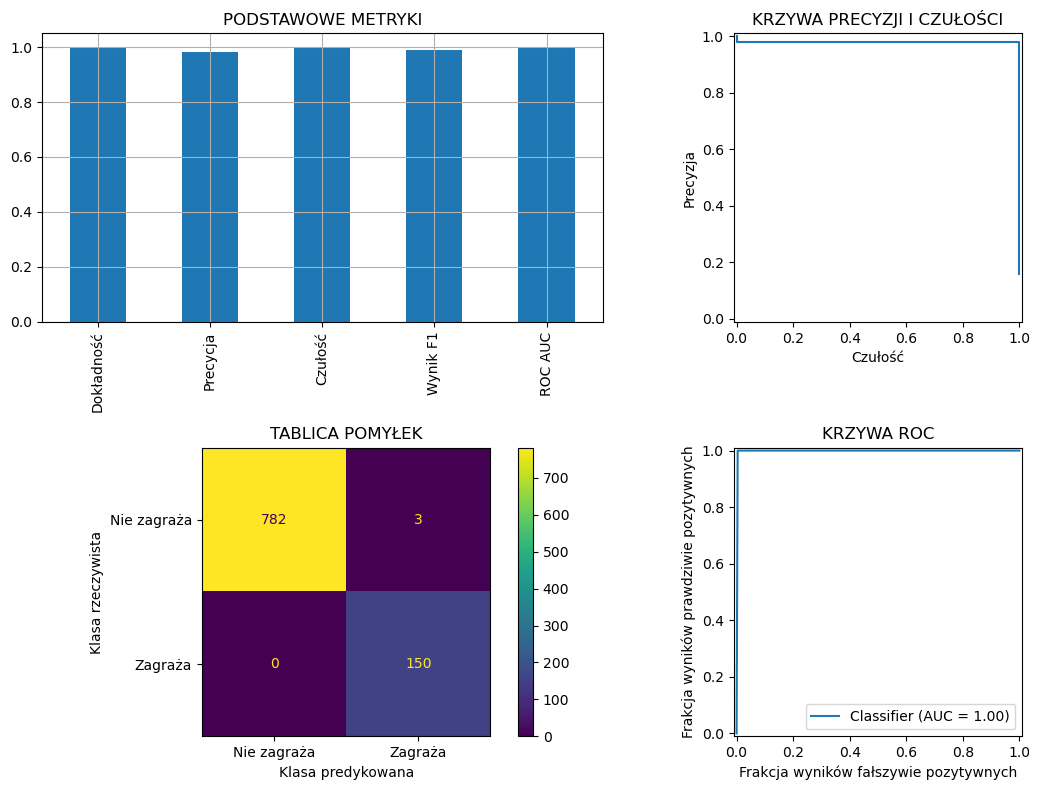

In [99]:
dt = train_evaluate_model(models['Drzewo decyzyjne'], 'Drzewo decyzyjne')

**Interpretacja:**

Dokładność jest bardzo wysoka, blisko 100% próbek zostało sklasyfikowanych prawidłowo. Ta metryka nie jest zbyt wiarygodna dla niezbalansowanych zbiorów, takich jak ten (785 próbek klasy 0 kontra 150 próbek klasy 1).

Precyzja jest bardzo wysoka, ponad 98% wszystkich próbek sklasyfikowanych jako pozytywne było sklasyfikowanych prawidłowo, co wskazuje na niewielką liczbę fałszywie pozytywnych.

Czułość jest bardzo wysoka, 100% wszystkich rzeczywistych pozytywnych zostało sklasyfowane prawidłowo, więc model klasyfikuje pozytywne bardzo dobrze.

Wynik F1 jest bardzo wysoki, więc model charakteryzuje się dobrym balansem pomiędzy prawidłową klasyfikacją pozytywnych a unikaniem fałszywie pozytywnych.

ROC AUC jest bardzo wysokie, więc model dobrze radzi sobie z rozróżnianiem klas.

Z raportu klasyfikacji możemy wywnioskować co następuje:

- dla klasy 0 (negatywne, klasa większościowa):<br>
Precyzja: wszystkie klasyfikacje negatywne są prawidłowe,<br>
Czułość: wszystkie rzeczywiste negatywne są sklasyfikowane prawidłowo,<br>
Wynik F1: model radzi sobie bardzo dobrze z negatywnymi<br>

- dla klasy 1 (pozytywne, klasa mniejszościowa):<br>
Precyzja: prawie wszystkie klasyfikacje pozytywne są prawidłowe,<br>
Czułość: wszystkie rzeczywiste pozytywne są sklasyfikowane prawidłowo,<br>
Wynik F1: model radzi sobie bardzo dobrze z pozytywnymi<br>

Krzywa precyzji i czułości dochodzi do prawego górnego rogu, więc model bardzo dobrze sobie radzi z balansowaniem precyzji i czułości. 

W tablicy pomyłek widzimy, że:
- liczba klasyfikacji prawdziwie pozytywnych: 150 - tyle razy rzeczywisty obiekt zagrażający został prawidłowo sklasyfikowany jako obiekt zagrażający,
- liczba klasyfikacji fałszywie pozytywnych: 3 - tyle razy rzeczywisty obiekt niezagrażający został nieprawidłowo sklasyfikowana jako obiekt zagrażający,
- liczba klasyfikacji prawdziwie negatywnych: 782 - tyle razy rzeczywisty obiekt niezagrażający został prawidłowo sklasyfikowany jako obiekt niezagrażający,
- liczba klasyfikacji fałszywie negatywnych: 0 - tyle razy rzeczywisty obiekt zagrażający został nieprawidłowo sklasyfikowany jako obiekt niezagrażający 

W tym przypadku najważniejsza jest minimalizacja liczby klasyfikacji fałszywie negatywnych. Na szczęście w tym modelu liczba obiektów zagrażających sklasyfikowanych jako obiekty niezagrażające jest niewielka.

Krzywa ROC dochodzi do lewego górnego rogu, więc można powiedzieć, że model radzi sobie z klasyfikacją bardzo dobrze.

#### Las losowy

Las losowy to zbiór drzew decyzyjnych, gdzie predykcje są uśrednione, co redukuje nadmierne dopasowanie. 

LAS LOSOWY

METRYKI KLASYFIKACJI

Dokładność: 0.9936
Precycja: 0.9675
Czułość: 0.9933
Wynik F1: 0.9803
ROC AUC: 0.9999

RAPORT Z KLASYFIKACJI

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       785
           1       0.97      0.99      0.98       150

    accuracy                           0.99       935
   macro avg       0.98      0.99      0.99       935
weighted avg       0.99      0.99      0.99       935




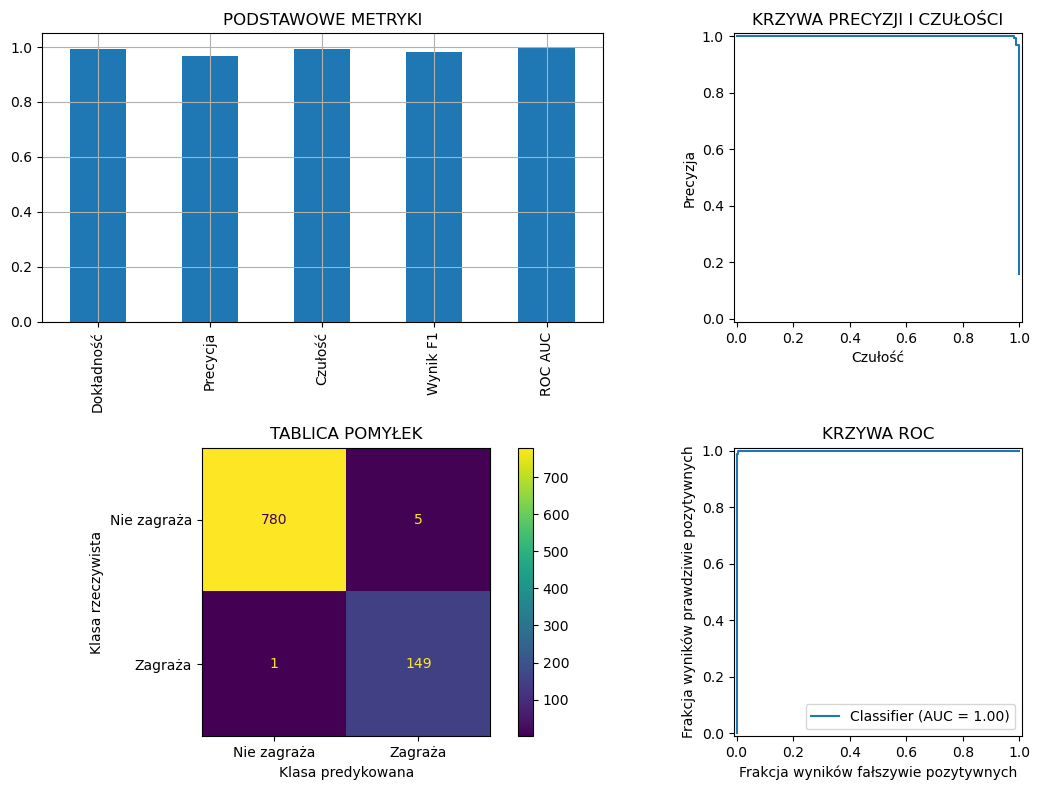

In [100]:
rf = train_evaluate_model(models['Las losowy'], 'Las losowy')

**Interpretacja:**

Dokładność jest bardzo wysoka, blisko 100% próbek zostało sklasyfikowanych prawidłowo. Ta metryka nie jest zbyt wiarygodna dla niezbalansowanych zbiorów, takich jak ten (785 próbek klasy 0 kontra 150 próbek klasy 1).

Precyzja jest wysoka, ponad 96% wszystkich próbek sklasyfikowanych jako pozytywne było sklasyfikowanych prawidłowo, co wskazuje na niewielką liczbę fałszywie pozytywnych.

Czułość jest wysoka, ponad 99% wszystkich rzeczywistych pozytywnych zostało sklasyfowane prawidłowo, więc model klasyfikuje pozytywne dość dobrze.

Wynik F1 jest bardzo wysoki, więc model charakteryzuje się bardzo dobrym balansem pomiędzy prawidłową klasyfikacją pozytywnych a unikaniem fałszywie pozytywnych.

ROC AUC jest bardzo wysokie, więc model dobrze radzi sobie z rozróżnianiem klas.

Z raportu klasyfikacji możemy wywnioskować co następuje:

- dla klasy 0 (negatywne, klasa większościowa):<br>
Precyzja: praktycznie wszystkie klasyfikacje negatywne są prawidłowe,<br>
Czułość: prawie wszystkie rzeczywiste negatywne są sklasyfikowane prawidłowo,<br>
Wynik F1: model radzi sobie bardzo dobrze z negatywnymi<br>

- dla klasy 1 (pozytywne, klasa mniejszościowa):<br>
Precyzja: prawie wszystkie klasyfikacje pozytywne są prawidłowe,<br>
Czułość: prawie wszystkie rzeczywiste pozytywne są sklasyfikowane prawidłowo,<br>
Wynik F1: model radzi sobie dobrze z pozytywnymi<br>

Krzywa precyzji i czułości zbliża się bardzo blisko prawego górnego rogu, więc model bardzo dobrze sobie radzi z balansowaniem precyzji i czułości. 

W tablicy pomyłek widzimy, że:
- liczba klasyfikacji prawdziwie pozytywnych: 149 - tyle razy rzeczywisty obiekt zagrażający został prawidłowo sklasyfikowany jako obiekt zagrażający,
- liczba klasyfikacji fałszywie pozytywnych: 5 - tyle razy rzeczywisty obiekt niezagrażający został nieprawidłowo sklasyfikowana jako obiekt zagrażający,
- liczba klasyfikacji prawdziwie negatywnych: 780 - tyle razy rzeczywisty obiekt niezagrażający został prawidłowo sklasyfikowany jako obiekt niezagrażający,
- liczba klasyfikacji fałszywie negatywnych: 1 - tyle razy rzeczywisty obiekt zagrażający został nieprawidłowo sklasyfikowany jako obiekt niezagrażający 

W tym przypadku najważniejsza jest minimalizacja liczby klasyfikacji fałszywie negatywnych. Na szczęście w tym modelu liczba obiektów zagrażających sklasyfikowanych jako obiekty niezagrażające jest niewielka.

Krzywa ROC dochodzi bardzo blisko lewego górnego rogu, więc można powiedzieć, że model radzi sobie z klasyfikacją bardzo dobrze.

#### Wzmocnienie gradientowe

Wzmocnienie gradientowe to model, który sekwencyjnie buduje drzewa decyzyjne, każdorazowo korygując błędy z poprzednich drzew.

WZMOCNIENIE GRADIENTOWE

METRYKI KLASYFIKACJI

Dokładność: 0.9925
Precycja: 0.9673
Czułość: 0.9867
Wynik F1: 0.9769
ROC AUC: 0.9999

RAPORT Z KLASYFIKACJI

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       785
           1       0.97      0.99      0.98       150

    accuracy                           0.99       935
   macro avg       0.98      0.99      0.99       935
weighted avg       0.99      0.99      0.99       935




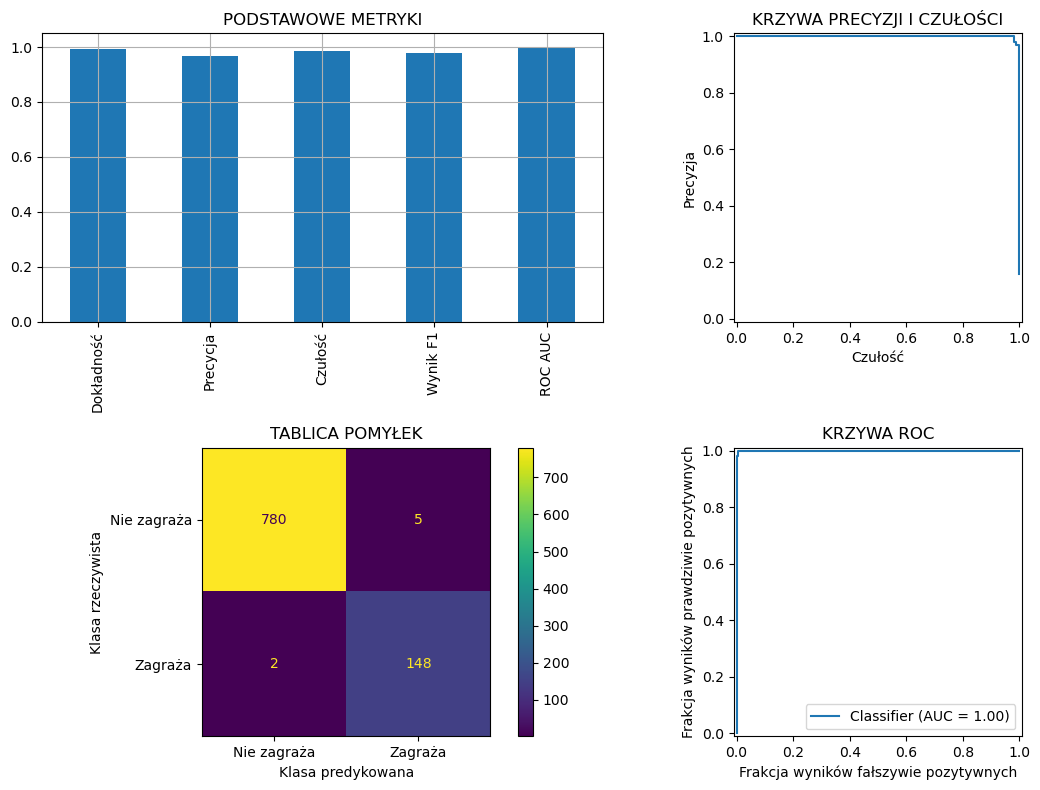

In [101]:
gb = train_evaluate_model(models['Wzmocnienie gradientowe'], 'Wzmocnienie gradientowe')

**Interpretacja:**

Dokładność jest bardzo wysoka, ponad 99% próbek zostało sklasyfikowanych prawidłowo. Ta metryka nie jest zbyt wiarygodna dla niezbalansowanych zbiorów, takich jak ten (785 próbek klasy 0 kontra 150 próbek klasy 1).

Precyzja jest wysoka, ponad 96% wszystkich próbek sklasyfikowanych jako pozytywne było sklasyfikowanych prawidłowo, co wskazuje na niewielką liczbę fałszywie pozytywnych.

Czułość jest wysoka, ponad 98% wszystkich rzeczywistych pozytywnych zostało sklasyfowane prawidłowo, więc model klasyfikuje pozytywne dość dobrze.

Wynik F1 jest bardzo wysoki, więc model charakteryzuje się bardzo dobrym balansem pomiędzy prawidłową klasyfikacją pozytywnych a unikaniem fałszywie pozytywnych.

ROC AUC jest bardzo wysokie, więc model dobrze radzi sobie z rozróżnianiem klas.

Z raportu klasyfikacji możemy wywnioskować co następuje:

- dla klasy 0 (negatywne, klasa większościowa):<br>
Precyzja: praktycznie wszystkie klasyfikacje negatywne są prawidłowe,<br>
Czułość: prawie wszystkie rzeczywiste negatywne są sklasyfikowane prawidłowo,<br>
Wynik F1: model radzi sobie bardzo dobrze z negatywnymi<br>

- dla klasy 1 (pozytywne, klasa mniejszościowa):<br>
Precyzja: prawie wszystkie klasyfikacje pozytywne są prawidłowe,<br>
Czułość: prawie wszystkie rzeczywiste pozytywne są sklasyfikowane prawidłowo,<br>
Wynik F1: model radzi sobie dobrze z pozytywnymi<br>

Krzywa precyzji i czułości zbliża się bardzo blisko prawego górnego rogu, więc model bardzo dobrze sobie radzi z balansowaniem precyzji i czułości. 

W tablicy pomyłek widzimy, że:
- liczba klasyfikacji prawdziwie pozytywnych: 148 - tyle razy rzeczywisty obiekt zagrażający został prawidłowo sklasyfikowany jako obiekt zagrażający,
- liczba klasyfikacji fałszywie pozytywnych: 5 - tyle razy rzeczywisty obiekt niezagrażający został nieprawidłowo sklasyfikowana jako obiekt zagrażający,
- liczba klasyfikacji prawdziwie negatywnych: 780 - tyle razy rzeczywisty obiekt niezagrażający został prawidłowo sklasyfikowany jako obiekt niezagrażający,
- liczba klasyfikacji fałszywie negatywnych: 2 - tyle razy rzeczywisty obiekt zagrażający został nieprawidłowo sklasyfikowany jako obiekt niezagrażający 

W tym przypadku najważniejsza jest minimalizacja liczby klasyfikacji fałszywie negatywnych. Na szczęście w tym modelu liczba obiektów zagrażających sklasyfikowanych jako obiekty niezagrażające jest niewielka.

Krzywa ROC dochodzi bardzo blisko lewego górnego rogu, więc można powiedzieć, że model radzi sobie z klasyfikacją bardzo dobrze.

#### Extra Trees

Extra Trees to zbiór drzew decyzyjnych, podobnie jak las losowy, ale podziały w drzewach są losowe, co przyspiesza trenowanie i redukuje wariancję.

EXTRA TREES

METRYKI KLASYFIKACJI

Dokładność: 0.9840
Precycja: 0.9592
Czułość: 0.9400
Wynik F1: 0.9495
ROC AUC: 0.9981

RAPORT Z KLASYFIKACJI

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       785
           1       0.96      0.94      0.95       150

    accuracy                           0.98       935
   macro avg       0.97      0.97      0.97       935
weighted avg       0.98      0.98      0.98       935




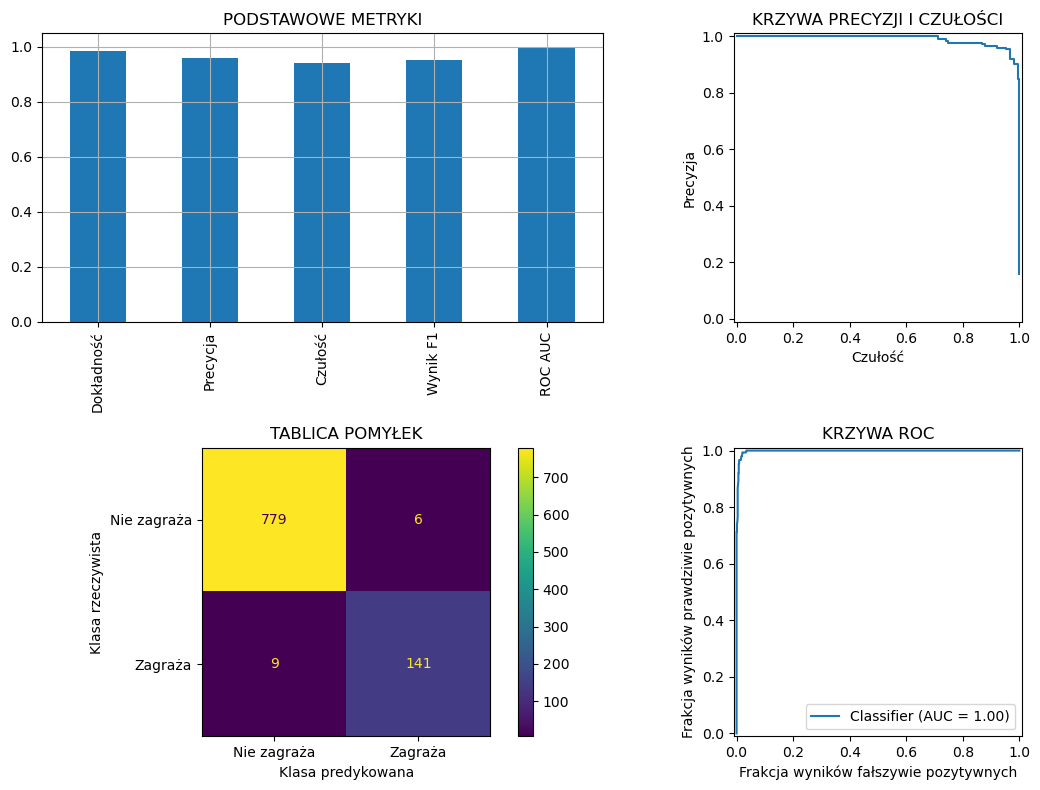

In [102]:
et = train_evaluate_model(models['Extra Trees'], 'Extra Trees')

**Interpretacja:**

Dokładność jest bardzo wysoka, ponad 98% próbek zostało sklasyfikowanych prawidłowo. Ta metryka nie jest zbyt wiarygodna dla niezbalansowanych zbiorów, takich jak ten (785 próbek klasy 0 kontra 150 próbek klasy 1).

Precyzja jest wysoka, prawie 96% wszystkich próbek sklasyfikowanych jako pozytywne było sklasyfikowanych prawidłowo, co wskazuje na niewielką liczbę fałszywie pozytywnych.

Czułość jest wysoka, 94% wszystkich rzeczywistych pozytywnych zostało sklasyfowane prawidłowo, więc model klasyfikuje pozytywne dość dobrze.

Wynik F1 jest bardzo wysoki, więc model charakteryzuje się bardzo dobrym balansem pomiędzy prawidłową klasyfikacją pozytywnych a unikaniem fałszywie pozytywnych.

ROC AUC jest bardzo wysokie, więc model dobrze radzi sobie z rozróżnianiem klas.

Z raportu klasyfikacji możemy wywnioskować co następuje:

- dla klasy 0 (negatywne, klasa większościowa):<br>
Precyzja: prawie wszystkie klasyfikacje negatywne są prawidłowe,<br>
Czułość: prawie wszystkie rzeczywiste negatywne są sklasyfikowane prawidłowo,<br>
Wynik F1: model radzi sobie bardzo dobrze z negatywnymi<br>

- dla klasy 1 (pozytywne, klasa mniejszościowa):<br>
Precyzja: prawie wszystkie klasyfikacje pozytywne są prawidłowe,<br>
Czułość: prawie wszystkie rzeczywiste pozytywne są sklasyfikowane prawidłowo,<br>
Wynik F1: model radzi sobie dobrze z pozytywnymi<br>

Krzywa precyzji i czułości zbliża się bardzo blisko prawego górnego rogu, więc model bardzo dobrze sobie radzi z balansowaniem precyzji i czułości. 

W tablicy pomyłek widzimy, że:
- liczba klasyfikacji prawdziwie pozytywnych: 141 - tyle razy rzeczywisty obiekt zagrażający został prawidłowo sklasyfikowany jako obiekt zagrażający,
- liczba klasyfikacji fałszywie pozytywnych: 6 - tyle razy rzeczywisty obiekt niezagrażający został nieprawidłowo sklasyfikowana jako obiekt zagrażający,
- liczba klasyfikacji prawdziwie negatywnych: 779 - tyle razy rzeczywisty obiekt niezagrażający został prawidłowo sklasyfikowany jako obiekt niezagrażający,
- liczba klasyfikacji fałszywie negatywnych: 9 - tyle razy rzeczywisty obiekt zagrażający został nieprawidłowo sklasyfikowany jako obiekt niezagrażający 

W tym przypadku najważniejsza jest minimalizacja liczby klasyfikacji fałszywie negatywnych. Na szczęście w tym modelu liczba obiektów zagrażających sklasyfikowanych jako obiekty niezagrażające jest niewielka.

Krzywa ROC dochodzi bardzo blisko lewego górnego rogu, więc można powiedzieć, że model radzi sobie z klasyfikacją bardzo dobrze.

#### XGBoost

XGBoost to wydajna i skalowalna implementacja wzmocnienia gradientowego, obejmująca takie cechy jak regularyzacja i wczesne zatrzymanie.

XGBOOST

METRYKI KLASYFIKACJI

Dokładność: 0.9957
Precycja: 0.9740
Czułość: 1.0000
Wynik F1: 0.9868
ROC AUC: 0.9997

RAPORT Z KLASYFIKACJI

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       785
           1       0.97      1.00      0.99       150

    accuracy                           1.00       935
   macro avg       0.99      1.00      0.99       935
weighted avg       1.00      1.00      1.00       935




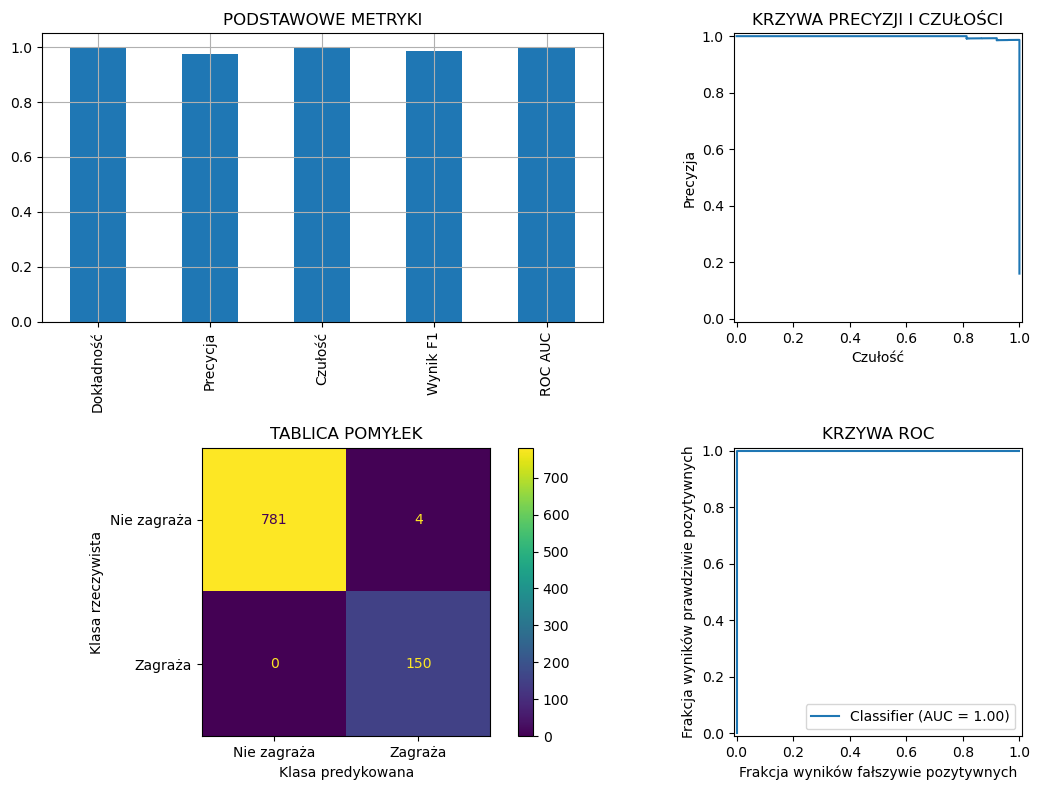

In [103]:
xgb = train_evaluate_model(models['XGBoost'], 'XGBoost')

**Interpretacja:**

Dokładność jest bardzo wysoka, blisko 100% próbek zostało sklasyfikowanych prawidłowo. Ta metryka nie jest zbyt wiarygodna dla niezbalansowanych zbiorów, takich jak ten (785 próbek klasy 0 kontra 150 próbek klasy 1).

Precyzja jest wysoka, ponad 97% wszystkich próbek sklasyfikowanych jako pozytywne było sklasyfikowanych prawidłowo, co wskazuje na niewielką liczbę fałszywie pozytywnych.

Czułość jest bardzo wysoka, 100% wszystkich rzeczywistych pozytywnych zostało sklasyfowane prawidłowo, więc model klasyfikuje pozytywne dość dobrze.

Wynik F1 jest bardzo wysoki, więc model charakteryzuje się bardzo dobrym balansem pomiędzy prawidłową klasyfikacją pozytywnych a unikaniem fałszywie pozytywnych.

ROC AUC jest bardzo wysokie, więc model dobrze radzi sobie z rozróżnianiem klas.

Z raportu klasyfikacji możemy wywnioskować co następuje:

- dla klasy 0 (negatywne, klasa większościowa):<br>
Precyzja: wszystkie klasyfikacje negatywne są prawidłowe,<br>
Czułość: wszystkie rzeczywiste negatywne są sklasyfikowane prawidłowo,<br>
Wynik F1: model radzi sobie bardzo dobrze z negatywnymi<br>

- dla klasy 1 (pozytywne, klasa mniejszościowa):<br>
Precyzja: prawie wszystkie klasyfikacje pozytywne są prawidłowe,<br>
Czułość: prawie wszystkie rzeczywiste pozytywne są sklasyfikowane prawidłowo,<br>
Wynik F1: model radzi sobie bardzo dobrze z pozytywnymi<br>

Krzywa precyzji i czułości zbliża się bardzo blisko prawego górnego rogu, więc model bardzo dobrze sobie radzi z balansowaniem precyzji i czułości. 

W tablicy pomyłek widzimy, że:
- liczba klasyfikacji prawdziwie pozytywnych: 150 - tyle razy rzeczywisty obiekt zagrażający został prawidłowo sklasyfikowany jako obiekt zagrażający,
- liczba klasyfikacji fałszywie pozytywnych: 4 - tyle razy rzeczywisty obiekt niezagrażający został nieprawidłowo sklasyfikowana jako obiekt zagrażający,
- liczba klasyfikacji prawdziwie negatywnych: 781 - tyle razy rzeczywisty obiekt niezagrażający został prawidłowo sklasyfikowany jako obiekt niezagrażający,
- liczba klasyfikacji fałszywie negatywnych: 0 - tyle razy rzeczywisty obiekt zagrażający został nieprawidłowo sklasyfikowany jako obiekt niezagrażający 

W tym przypadku najważniejsza jest minimalizacja liczby klasyfikacji fałszywie negatywnych. Na szczęście w tym modelu liczba obiektów zagrażających sklasyfikowanych jako obiekty niezagrażające jest niewielka.

Krzywa ROC dochodzi bardzo blisko lewego górnego rogu, więc można powiedzieć, że model radzi sobie z klasyfikacją bardzo dobrze.

### Model uczenia głębokiego (Deep Learning)

Zobaczmy jak model uczenia głębokiego radzi sobie w porównaniu z modelami tradycyjnymi. Wykorzystamy bibliotekę PyTorch do zbudowania prostego wielowarstwowego perceptrona (Multilayer Perceptron, MLP). MLP to sieć neuronowa z wieloma, w pełni połączonymi warstwami z nielinearnymi funkcjami aktywacji pomiędzy nimi.

Zacznijmy od zaimportowania odpowiednich elementów:

In [114]:
!pip install torch

In [104]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

Mamy już dane treningowe i testowe, ale w PyTorch dane te muszą być specjalnego typu, torch.Tensor, więc musimy je przekonwertować:

In [105]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)  # aby zapewnić, że y jest 2D
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1) # aby zapewnić, że y jest 2D

Teraz utworzymy zbiór treningowy i zbiór testowy. Następnie, używamy klasy DataLoader aby ustawić rozmiar partii (batch size) i mieszanie (shuffling):

In [106]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Zbudujmy sieć neuronową. Warstwa wyjściowa będzie składała się z jednego neuronu z funkcją aktywacji sigmoid, aby zapewnić, że wynik mieści się pomiędzy 0 a 1. Wewnątrz modelu użyjemy również innych funkcji aktywacji, takich jak ReLU i Linear:

In [107]:
class MLPModel(nn.Module):
    def __init__(self, input_size):
        super(MLPModel, self).__init__()

        # warstwy ukryte
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)

        # warstwa wyjściowa
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    # przepływ w przód
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

Zainicjalizujmy model:

In [108]:
# input size to liczba cech (jest 6 cech)
input_size = X_train.shape[1]  
mlp_model = MLPModel(input_size)

Teraz musimy wybrać funkcję straty i optymalizator. Jako funkcję straty przyjmiemy funkcję entropii krzyżowej dla klasyfikacji binarnej (binary cross-entropy loss function). Jako optymalizator przyjmiemy Adam. Ustawimy także współczynnik uczenia się na 0.01:

In [109]:
loss_function = nn.BCELoss()  
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

Teraz możemy zacząć trenowanie modelu. Trenujmy go przez 20 epok:

In [110]:
num_epochs = 20

for epoch in range(num_epochs):

    # tryb trenowania
    mlp_model.train() 
    
    epoch_loss = 0

    for features, labels in train_loader:
        # przepływ w przód
        outputs = mlp_model(features)
        loss = loss_function(outputs, labels)

        # przepływ wsteczny i optymalizacja
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}")

Epoch [1/20], Loss: 0.2835
Epoch [2/20], Loss: 0.1012
Epoch [3/20], Loss: 0.0729
Epoch [4/20], Loss: 0.0621
Epoch [5/20], Loss: 0.0532
Epoch [6/20], Loss: 0.0474
Epoch [7/20], Loss: 0.0430
Epoch [8/20], Loss: 0.0378
Epoch [9/20], Loss: 0.0362
Epoch [10/20], Loss: 0.0344
Epoch [11/20], Loss: 0.0296
Epoch [12/20], Loss: 0.0274
Epoch [13/20], Loss: 0.0269
Epoch [14/20], Loss: 0.0252
Epoch [15/20], Loss: 0.0223
Epoch [16/20], Loss: 0.0222
Epoch [17/20], Loss: 0.0199
Epoch [18/20], Loss: 0.0197
Epoch [19/20], Loss: 0.0176
Epoch [20/20], Loss: 0.0178


Jak widać, strata cały czas spada, ale nie za szybko, więc liczba epok jest dobra. Teraz sprawdźmy metryki. Użyjemy tych samych metryk co w tradycyjnym uczeniu maszynowym. 

Dla klasyfikacji zastosujemy próg 0.5, tak aby wartości powyżej 0.5 były uznane za prawdziwe. Oto ewaluacja modelu:

In [111]:
# tryb ewaluacji
mlp_model.eval()

threshhold = 0.5

y_true = [] # wartości prawdziwe
y_prob = [] # prawdopodobieństwa
y_pred = [] # predykcje

with torch.no_grad():
    for features, labels in test_loader:
        outputs = mlp_model(features)
        preds = (outputs > threshhold).float()  
        y_true.extend(labels.numpy().flatten())
        y_prob.extend(outputs.numpy().flatten())
        y_pred.extend(preds.numpy().flatten())

METRYKI KLASYFIKACJI

Dokładność: 0.9893
Precycja: 0.9730
Czułość: 0.9600
Wynik F1: 0.9664
ROC AUC: 0.9987

RAPORT Z KLASYFIKACJI

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       785
           1       0.97      0.96      0.97       150

    accuracy                           0.99       935
   macro avg       0.98      0.98      0.98       935
weighted avg       0.99      0.99      0.99       935




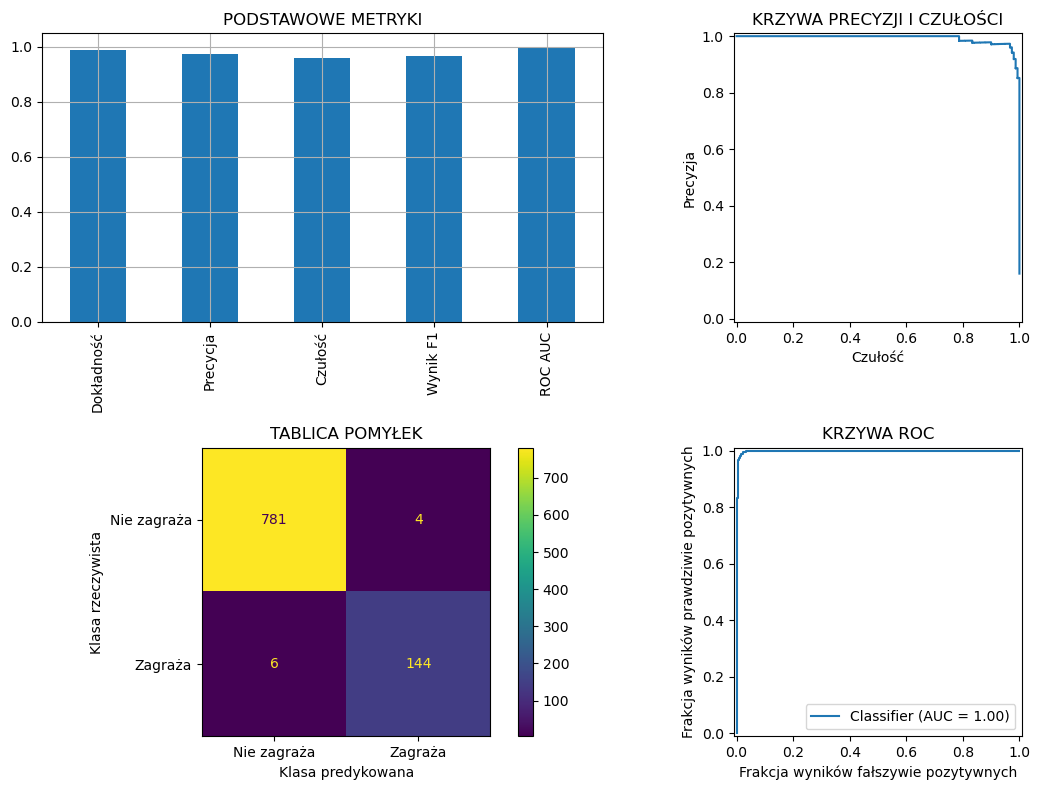

In [112]:
mlp = evaluate_model(y_test, y_pred, y_prob)

**Interpretacja:**

Dokładność jest bardzo wysoka, prawie 99% próbek zostało sklasyfikowanych prawidłowo. Ta metryka nie jest zbyt wiarygodna dla niezbalansowanych zbiorów, takich jak ten (785 próbek klasy 0 kontra 150 próbek klasy 1).

Precyzja jest wysoka, ponad 97% wszystkich próbek sklasyfikowanych jako pozytywne było sklasyfikowanych prawidłowo, co wskazuje na niewielką liczbę fałszywie pozytywnych.

Czułość jest bardzo wysoka, 96% wszystkich rzeczywistych pozytywnych zostało sklasyfowane prawidłowo, więc model klasyfikuje pozytywne dość dobrze.

Wynik F1 jest bardzo wysoki, więc model charakteryzuje się bardzo dobrym balansem pomiędzy prawidłową klasyfikacją pozytywnych a unikaniem fałszywie pozytywnych.

ROC AUC jest bardzo wysokie, więc model dobrze radzi sobie z rozróżnianiem klas.

Z raportu klasyfikacji możemy wywnioskować co następuje:

- dla klasy 0 (negatywne, klasa większościowa):<br>
Precyzja: prawie wszystkie klasyfikacje negatywne są prawidłowe,<br>
Czułość: prawie wszystkie rzeczywiste negatywne są sklasyfikowane prawidłowo,<br>
Wynik F1: model radzi sobie bardzo dobrze z negatywnymi<br>

- dla klasy 1 (pozytywne, klasa mniejszościowa):<br>
Precyzja: prawie wszystkie klasyfikacje pozytywne są prawidłowe,<br>
Czułość: prawie wszystkie rzeczywiste pozytywne są sklasyfikowane prawidłowo,<br>
Wynik F1: model radzi sobie bardzo dobrze z pozytywnymi<br>

Krzywa precyzji i czułości zbliża się bardzo blisko prawego górnego rogu, więc model bardzo dobrze sobie radzi z balansowaniem precyzji i czułości. 

W tablicy pomyłek widzimy, że:
- liczba klasyfikacji prawdziwie pozytywnych: 144 - tyle razy rzeczywisty obiekt zagrażający został prawidłowo sklasyfikowany jako obiekt zagrażający,
- liczba klasyfikacji fałszywie pozytywnych: 4 - tyle razy rzeczywisty obiekt niezagrażający został nieprawidłowo sklasyfikowana jako obiekt zagrażający,
- liczba klasyfikacji prawdziwie negatywnych: 781 - tyle razy rzeczywisty obiekt niezagrażający został prawidłowo sklasyfikowany jako obiekt niezagrażający,
- liczba klasyfikacji fałszywie negatywnych: 6 - tyle razy rzeczywisty obiekt zagrażający został nieprawidłowo sklasyfikowany jako obiekt niezagrażający 

W tym przypadku najważniejsza jest minimalizacja liczby klasyfikacji fałszywie negatywnych. Na szczęście w tym modelu liczba obiektów zagrażających sklasyfikowanych jako obiekty niezagrażające jest niewielka.

Krzywa ROC dochodzi bardzo blisko lewego górnego rogu, więc można powiedzieć, że model radzi sobie z klasyfikacją bardzo dobrze.

### Porównanie modeli

Mamy teraz metryki dla wszystkich modeli. Zachowywaliśmy je podczas trenowania modeli i teraz możemy je porównać. Umieśćmy je w liście: 

In [113]:
model_metrics_list = [gnb, lr, knn, dt, rf, gb, et, xgb, mlp]

Stwórzmy teraz DataFrame ze wszystkimi metrykami dla każdego modelu:

In [114]:
model_metrics = {
    'Gaussian Naive Bayes': gnb,
    'Logistic Regression': lr,
    'K-Nearest Neighbors': knn,
    'Decision Tree': dt,
    'Random Forest': rf,
    'Gradient Boosting': gb,
    'Extra Trees': et,
    'XGBoost': xgb,
    'Multilayer Perceptron': mlp
}

df_metrics = pd.DataFrame(model_metrics).T
df_metrics

,Dokładność,Precycja,Czułość,Wynik F1,ROC AUC
Gaussian Naive Bayes,0.935829,0.764706,0.866667,0.812500,0.978301
Logistic Regression,0.947594,0.806061,0.886667,0.844444,0.986701
K-Nearest Neighbors,0.935829,0.781250,0.833333,0.806452,0.974234
Decision Tree,0.996791,0.980392,1.000000,0.990099,0.998089
Random Forest,0.993583,0.967532,0.993333,0.980263,0.999907
Gradient Boosting,0.992513,0.967320,0.986667,0.976898,0.999890
Extra Trees,0.983957,0.959184,0.940000,0.949495,0.998127
XGBoost,0.995722,0.974026,1.000000,0.986842,0.999660
Multilayer Perceptron,0.989305,0.972973,0.960000,0.966443,0.998667


Następnie zwizualizujmy metryki tworząc wykresy słupkowe dla każdej z nich. W ten sposób będziemy mogli porównać wszystkie metryki dla wszystkich modeli. Kod umieścimy w funkcji:

In [115]:
def plot_metrics(df):
    fig, axes = plt.subplots(3, 2, figsize=(15, 15), constrained_layout=True)
    axes = axes.flatten()
    
    # oddzielny wykres dla każdej metryki
    for i, column in enumerate(df_metrics.columns):
        sns.barplot(data=df, x=df.index, y=column, palette='viridis', hue=df.index, ax=axes[i])
        axes[i].set_title(f'{column} - porównanie')
        axes[i].set_xlabel('')
        axes[i].set_ylabel(column)
        axes[i].tick_params(axis='x', rotation=80)
    
        # rzeczywiste wartości na słupkach
        for bar in axes[i].patches:
            axes[i].text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() - axes[i].patches[0].get_height() * 0.08,
                f'{bar.get_height():.4f}',
                color='white',
                ha='center',
                va='bottom',
                fontsize=9
            )
    
    # Możemy usunąć ostatni subplot
    fig.delaxes(axes[5])
    
    plt.show()

Wywołajmy naszą funkcję z DataFrame df_metrics:

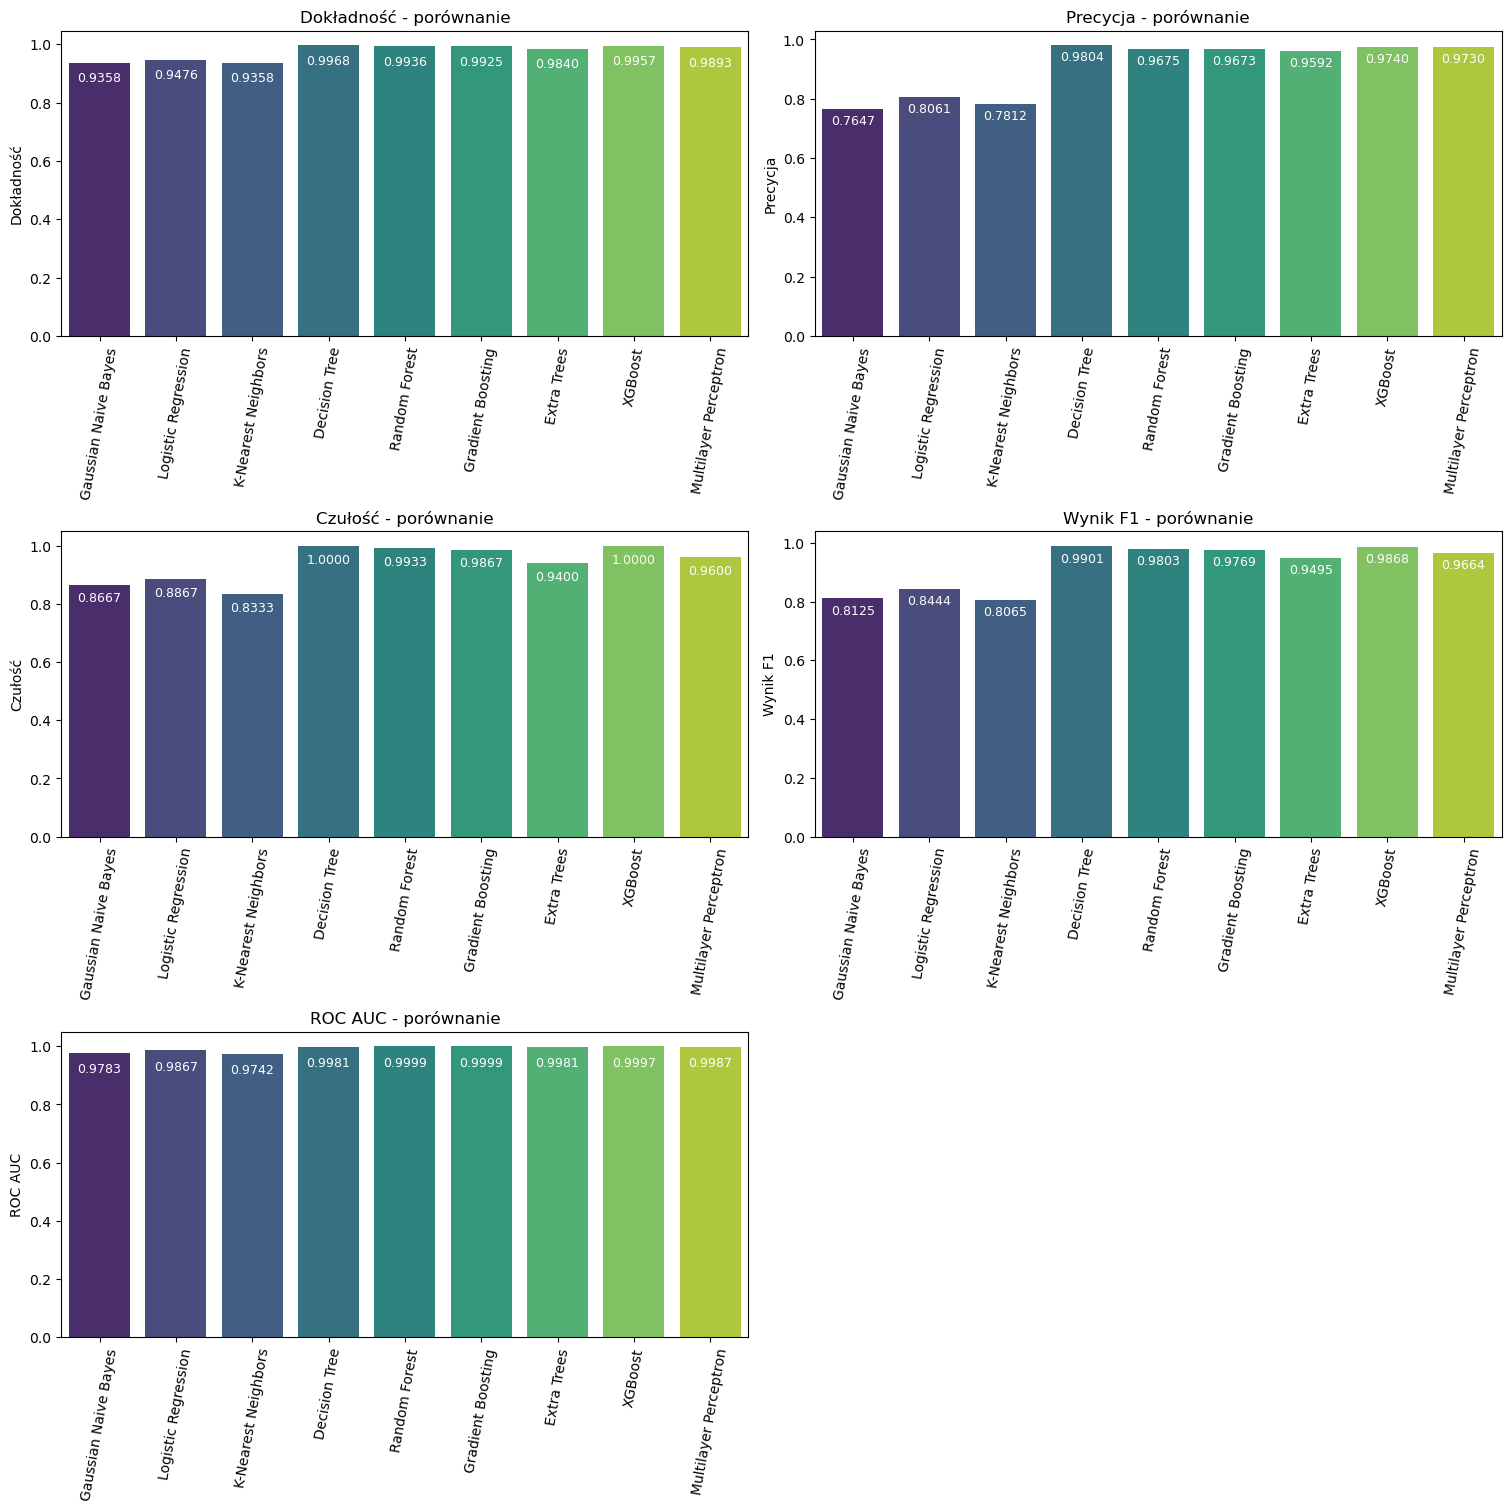

In [116]:
plot_metrics(df_metrics)

Jak już wspomniano, najważniejsze metryki to czułość i ROC AUC. Najlepiej wyglądają one w przypadku drzewa decyzyjnego, chociaż pozostałe modele także wypadają bardzo dobrze. Także inne metryki mają bardzo dobre wartości. W związku z tym nie będziemy dostrajać hiperparametrów, gdyż przy użyciu hiperparametrów domyślnych uzyskujemy bardzo dobry wynik.

## Wnioski

W zależności od cech naszego zbioru danych, możemy wybrać inne podejście do procesu uczenia maszynowego. Możemy wybrać jeden z modeli tradycyjnych, albo model uczenia głębokiego (deep learning).

Zanim nie wytrenujemy co najmniej kilku modeli, trudno jest powiedzieć, który model jest optymalny. Czasem modele tradycyjne radzą sobie lepiej, a czasem lepsze wyniki osiągają modele uczenia głębokiego.

Ważne jest także, aby prawidłowo porównywać modele. Znów, w zależności od rodzaju danych, na których pracujemy, musimy zdecydować, które metryki są najważniejsze. Na przykład predykcje na danych z naszego zbioru mogą decydować o życiu lub śmierci wielu osób. W przypadku tak wrażliwych danych, czułość jest ważniejsza niż pozostałe metryki, bo chcemy mieć pewność, że liczba przypadków pozytywnych sklasyfikowanych jako negatywne jest jak najmniejsza. W przypadku innych zbiorów danych mogą być inne priorytety.

Trenowanie kilku modeli umożliwia nam porównywanie metryk, na których nam zależy, a następnie poprawianie modelu, w którym mają one najlepsze wartości, na przykład przez dostrajanie hiperparametrów. Ten proces może poprawić jakość modelu, ale nie zawsze się tak dzieje. W przypadku niektórych zbiorów, takich jak ten, nie ma potrzeby dostrajania hiperparametrów, gdyż hiperparametry domyślne dają bardzo dobre wyniki.

Podsumowując, nie ma jednego jedynego słusznego podejścia czy modelu. Zawsze powinniśmy wypróbować co najmniej kilka modeli i porównać wyniki. Ostatecznie powinniśmy wybrać model, który radzi sobie najlepiej i używać go do pracy na danych tego samego rodzaju. Musimy jednak pamiętać, że nie musi to być wcale optymalny model dla innych typów danych.